In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
Q = np.diag([0.1])**2  # state prediction covariance error
R = np.diag([1.0, np.deg2rad(40.0)])**2  # measurment prediciton covariance error

#  Simulation parameter
Qsim = np.diag([0.2])**2
Rsim = np.diag([1.0, np.deg2rad(30.0)])**2

DT = 0.1  # delta time [s]
SIM_TIME = 50.0  # simulation time [s]
MAX_RANGE = 20.0  # maximum observation range

# Particle filter parameter
NP = 100  # Number of Particle
NTh = NP / 2.0  # Number of particle for re-sampling

show_animation = True

In [3]:
def calc_input():
    v = 1.0  # [m/s]
    cir_rate = 0.1  # [rad/s]
    u = np.array([[v, cir_rate]]).T
    return u

In [4]:
def motion_model(x, u):
    A = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 0.5]])

    B = np.array([[DT * math.cos(x[2, 0]), 0],
                  [DT * math.sin(x[2, 0]), 0],
                  [0.0, DT],
                  [1.0, 0.0]])

    x = A.dot(x) + B.dot(u)

    return x

In [5]:
def gauss_likelihood(x, sigma):
    p = 1.0 / math.sqrt(2.0 * math.pi * sigma ** 2) * \
        math.exp(-x ** 2 / (2 * sigma ** 2))

    return p

In [6]:
def calc_covariance(xEst, px, pw):
    cov = np.zeros((3, 3))

    for i in range(px.shape[1]):
        dx = (px[:, i] - xEst)[0:3]
        cov += pw[0, i] * dx.dot(dx.T)

    return cov

In [7]:
def observation(xTrue, xd, u, LM):
    xTrue = motion_model(xTrue, u)

    z = np.zeros((0, 3))

    for i in range(len(LM[:, 0])):

        dx = xTrue[0, 0] - LM[i, 0]
        dy = xTrue[1, 0] - LM[i, 1]
        d = math.sqrt(dx**2 + dy**2)
        if d <= MAX_RANGE:
            dn = d + np.random.randn() * Qsim[0, 0]  # add noise
            zi = np.array([[dn, LM[i, 0], LM[i, 1]]])
            z = np.vstack((z, zi))

    # control
    ud1 = u[0, 0] + np.random.randn() * Rsim[0, 0]
    ud2 = u[1, 0] + np.random.randn() * Rsim[1, 1]
    ud = np.array([[ud1, ud2]]).T

    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud

In [8]:
def pf_estimation(px, pw, xEst, PEst, z, u):
    for ip in range(NP):
        x = np.array([px[:, ip]]).T
        w = pw[0, ip]
        #  Predict with random input sampling
        ud1 = u[0, 0] + np.random.randn() * Rsim[0, 0]
        ud2 = u[1, 0] + np.random.randn() * Rsim[1, 1]
        ud = np.array([[ud1, ud2]]).T
        x = motion_model(x, ud)

        #  Calc Importance Weight
        for i in range(len(z[:, 0])):
            dx = x[0, 0] - z[i, 1]
            dy = x[1, 0] - z[i, 2]
            prez = math.sqrt(dx**2 + dy**2)
            dz = prez - z[i, 0]
            w = w * gauss_likelihood(dz, math.sqrt(Q[0, 0]))

        px[:, ip] = x[:, 0]
        pw[0, ip] = w

    pw = pw / pw.sum()  # normalize

    xEst = px.dot(pw.T)
    PEst = calc_covariance(xEst, px, pw)

    px, pw = resampling(px, pw)

    return xEst, PEst, px, pw

In [9]:
def resampling(px, pw):
    Neff = 1.0 / (pw.dot(pw.T))[0, 0]  # Effective particle number
    if Neff < NTh:
        wcum = np.cumsum(pw)
        base = np.cumsum(pw * 0.0 + 1 / NP) - 1 / NP
        resampleid = base + np.random.rand(base.shape[0]) / NP

        inds = []
        ind = 0
        for ip in range(NP):
            while resampleid[ip] > wcum[ind]:
                ind += 1
            inds.append(ind)

        px = px[:, inds]
        pw = np.zeros((1, NP)) + 1.0 / NP  # init weight

    return px, pw

In [10]:
def main():
    print(" start!!")

    time = 0.0

    # LM positions [x, y]
    LM = np.array([[10.0, 0.0],
                     [10.0, 10.0],
                     [0.0, 15.0],
                     [-5.0, 20.0]])

    # State Vector [x y phi v]'
    xEst = np.zeros((4, 1))
    xTrue = np.zeros((4, 1))
    PEst = np.eye(4)

    px = np.zeros((4, NP))  # Particle store
    pw = np.zeros((1, NP)) + 1.0 / NP  # Particle weight
    xDR = np.zeros((4, 1))  # Dead reckoning

    # history
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue

    while SIM_TIME >= time:
        time += DT
        u = calc_input()

        xTrue, z, xDR, ud = observation(xTrue, xDR, u, LM)

        xEst, PEst, px, pw = pf_estimation(px, pw, xEst, PEst, z, ud)

        # store data history
        hxEst = np.hstack((hxEst, xEst))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))

        if show_animation:
            plt.cla()

            for i in range(len(z[:, 0])):
                plt.plot([xTrue[0, 0], z[i, 1]], [xTrue[1, 0], z[i, 2]], "-k")
            plt.plot(LM[:, 0], LM[:, 1], "*k")
            plt.plot(px[0, :], px[1, :], ".r")
            plt.plot(np.array(hxTrue[0, :]).flatten(),
                     np.array(hxTrue[1, :]).flatten(), "-b")
            plt.plot(np.array(hxDR[0, :]).flatten(),
                     np.array(hxDR[1, :]).flatten(), "-g")
            plt.plot(np.array(hxEst[0, :]).flatten(),
                     np.array(hxEst[1, :]).flatten(), "-r")
            plt.axis("equal")
            plt.grid(True)
            plt.pause(0.001)

 start!!


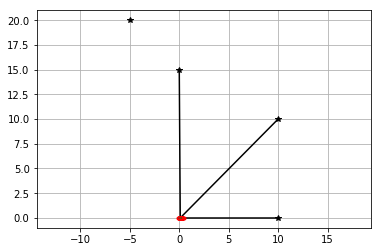

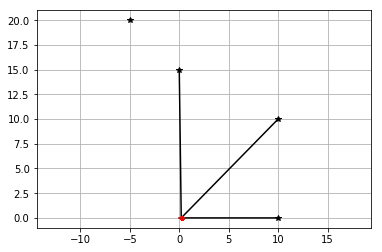

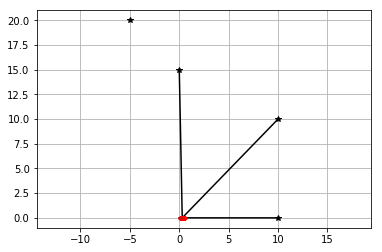

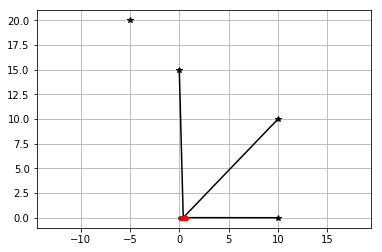

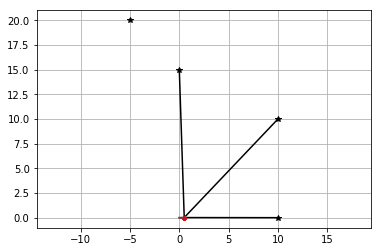

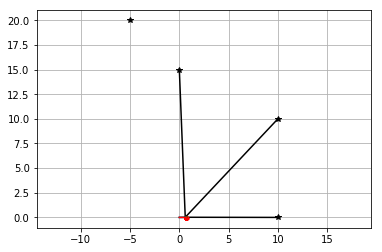

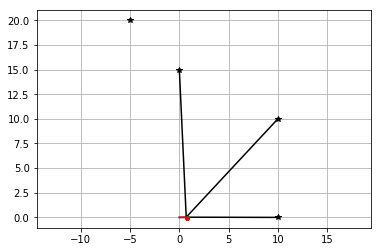

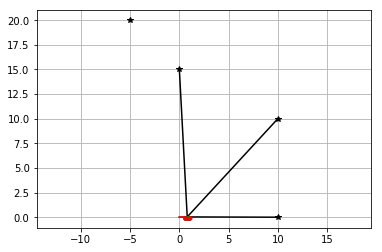

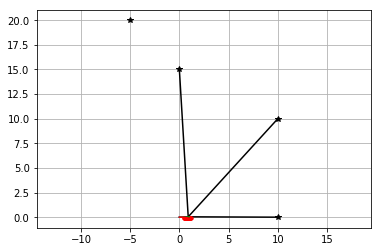

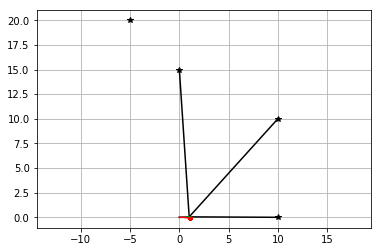

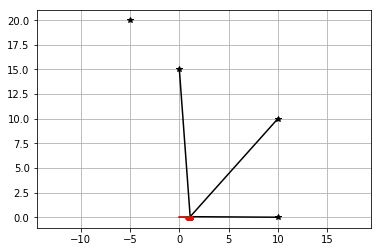

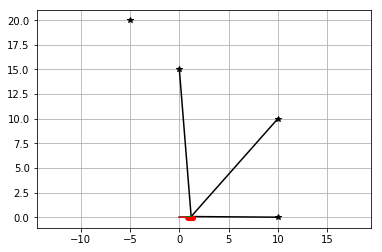

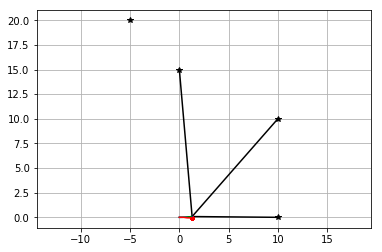

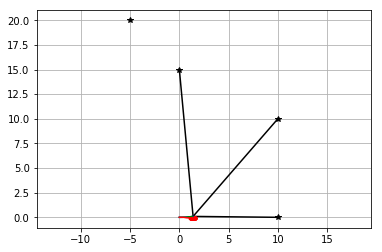

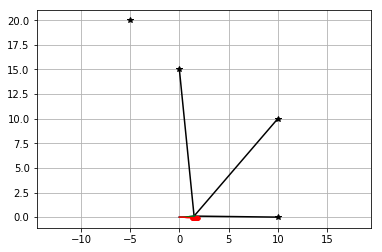

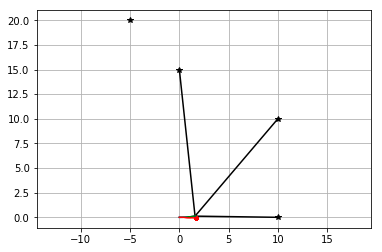

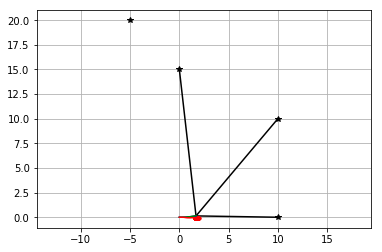

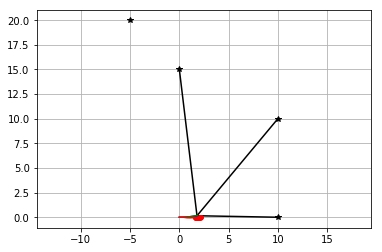

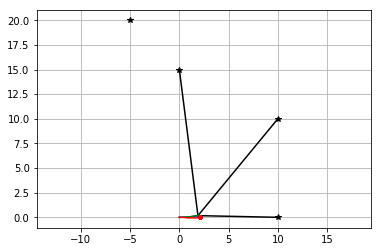

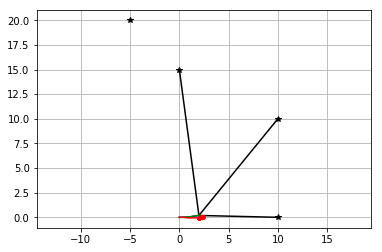

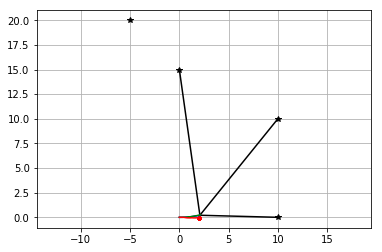

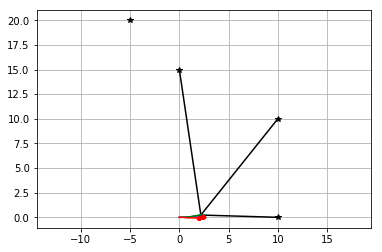

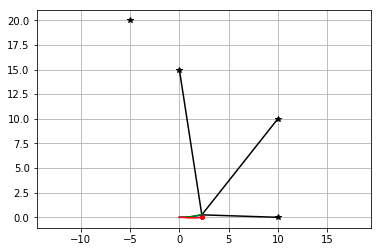

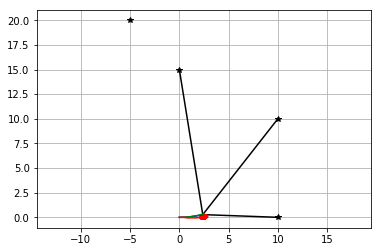

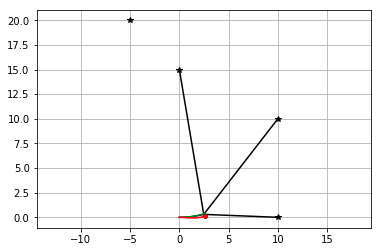

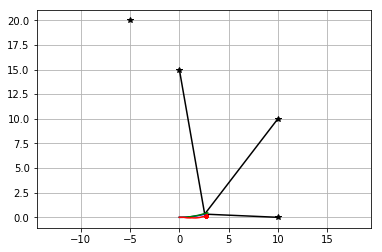

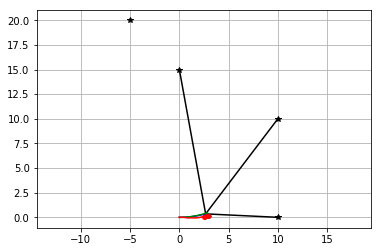

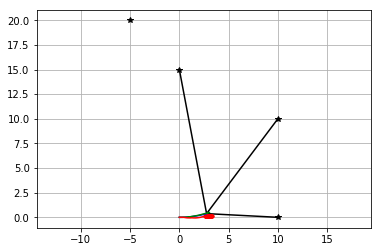

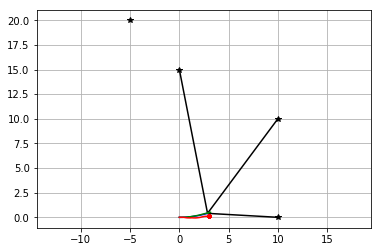

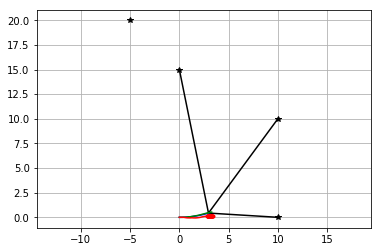

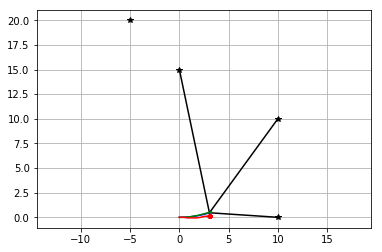

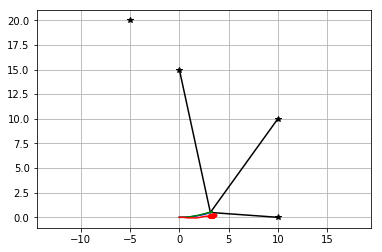

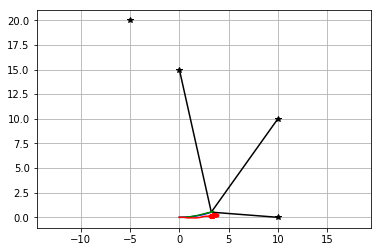

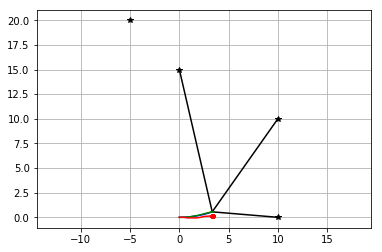

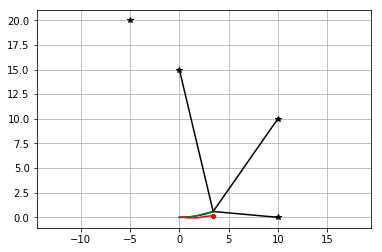

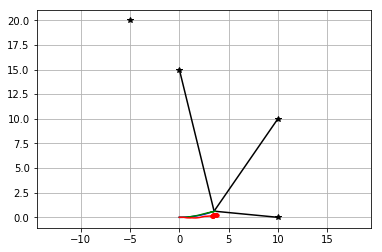

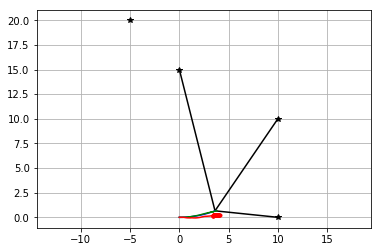

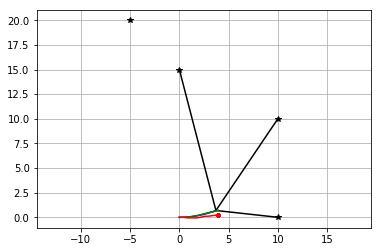

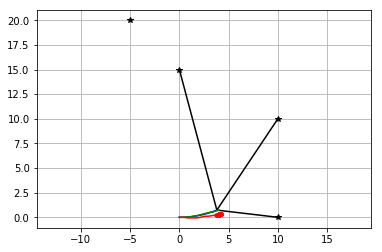

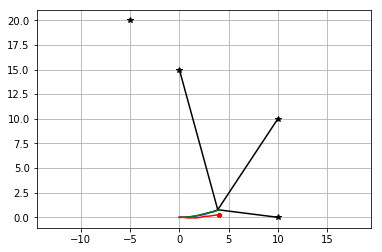

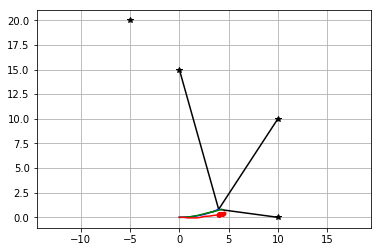

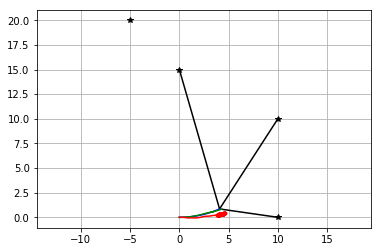

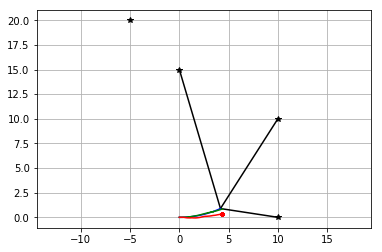

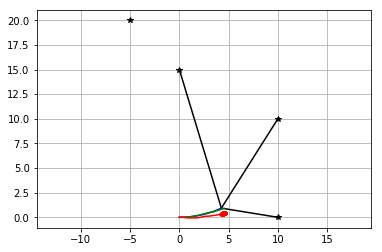

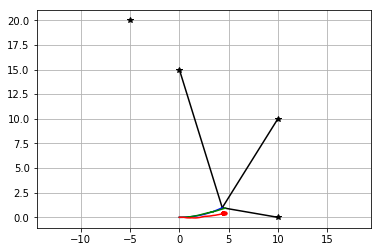

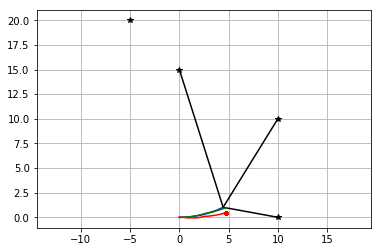

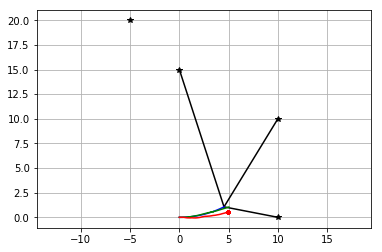

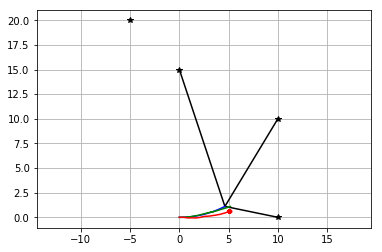

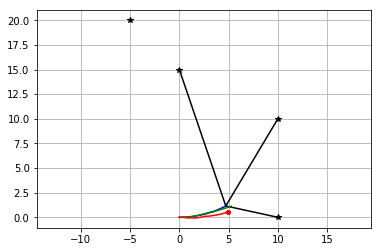

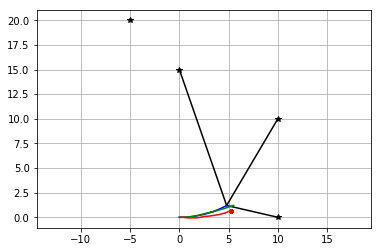

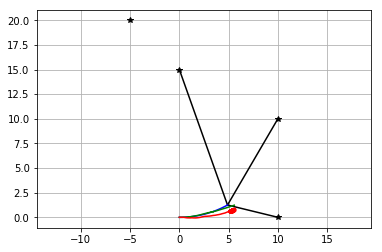

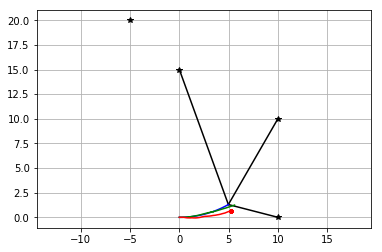

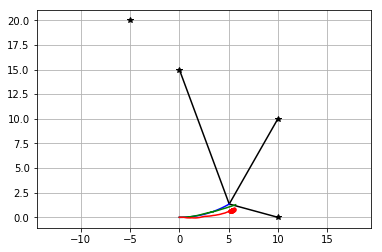

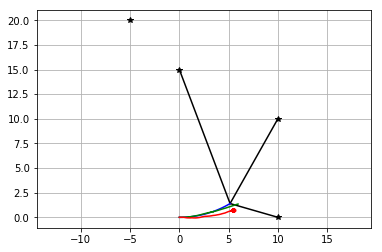

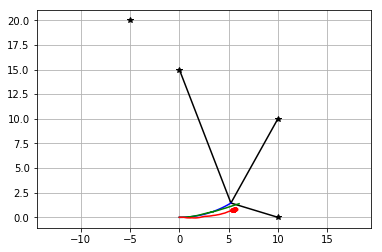

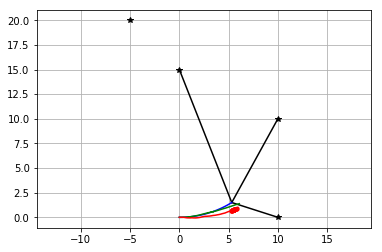

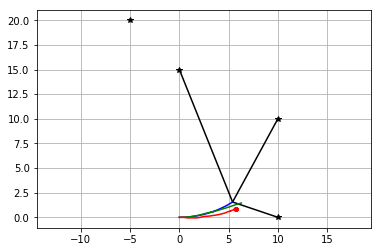

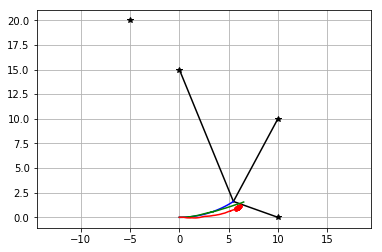

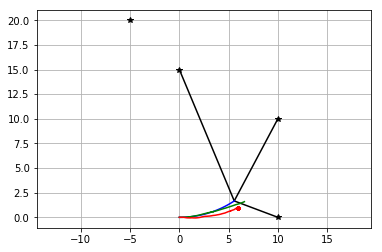

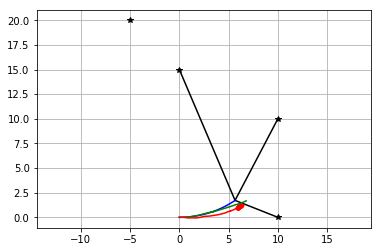

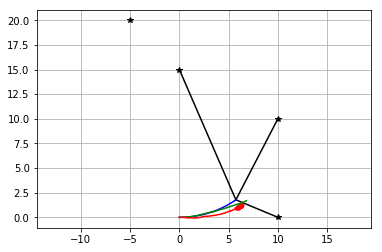

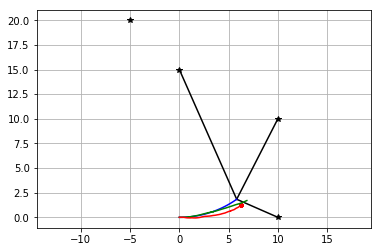

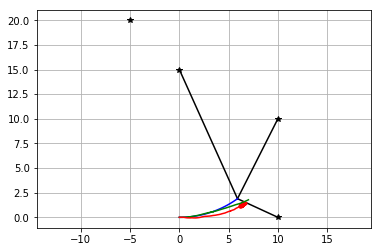

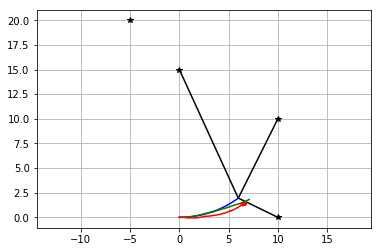

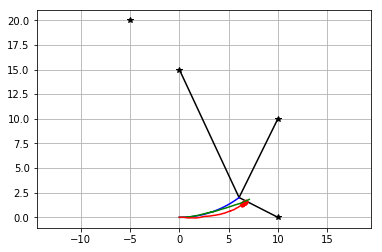

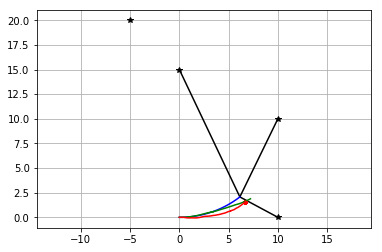

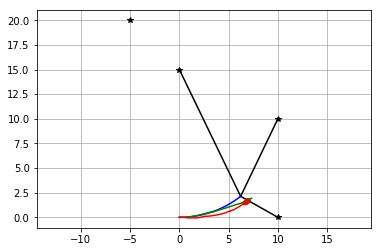

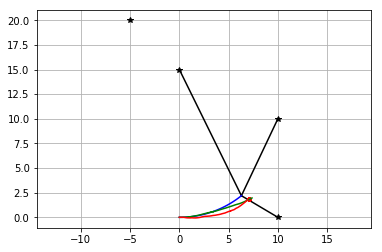

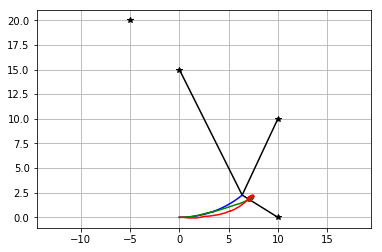

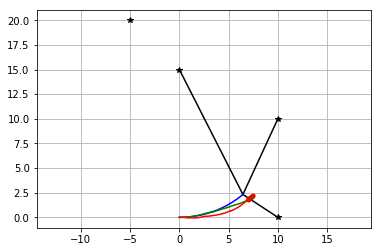

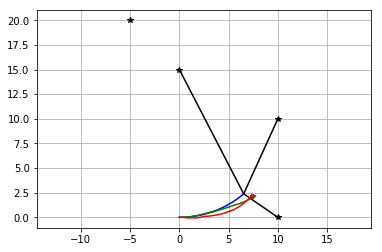

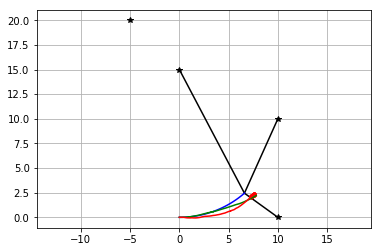

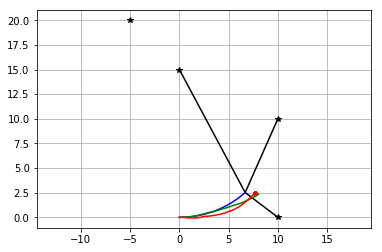

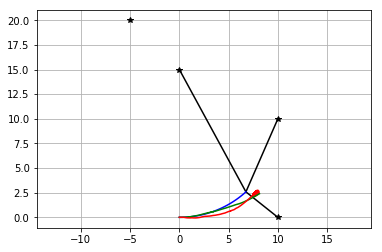

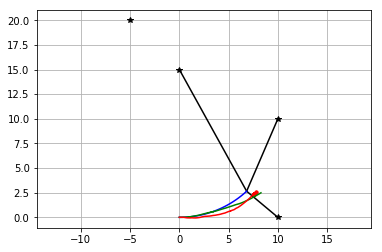

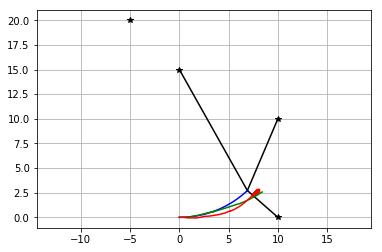

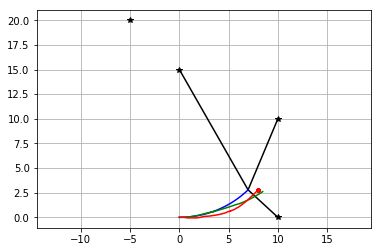

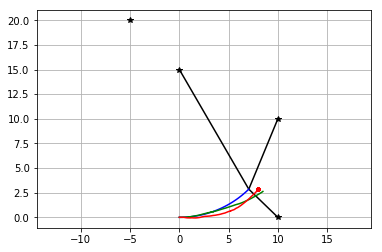

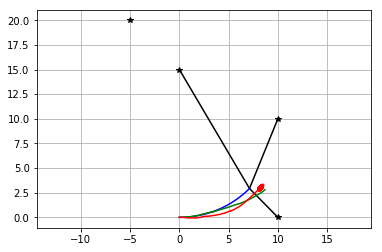

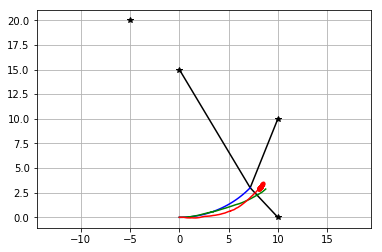

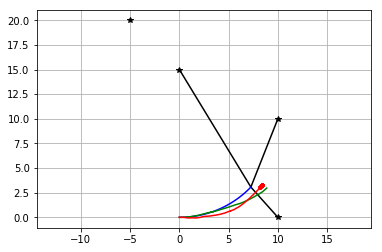

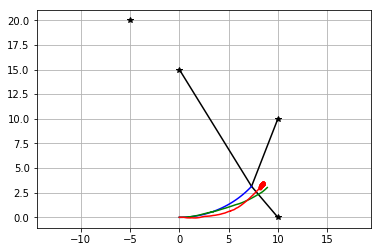

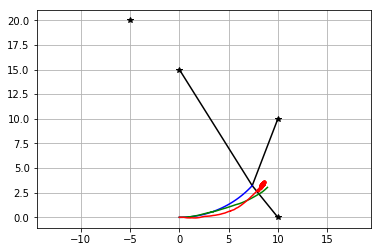

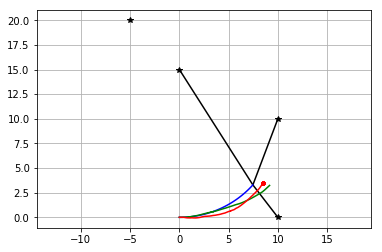

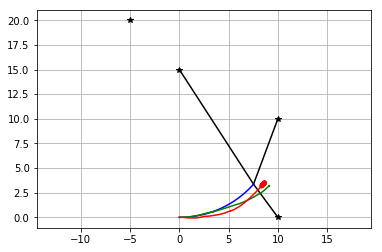

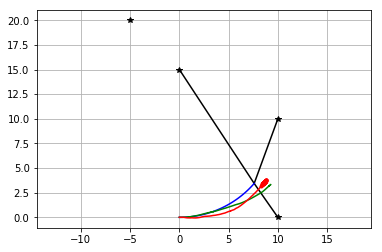

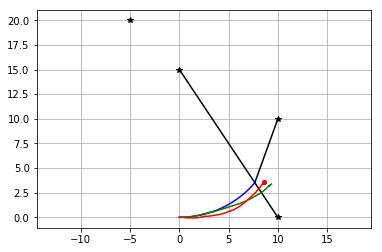

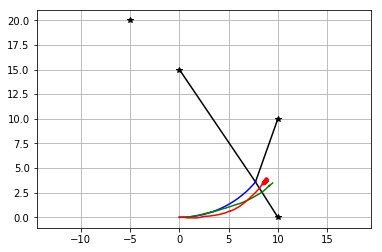

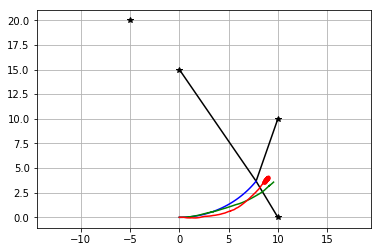

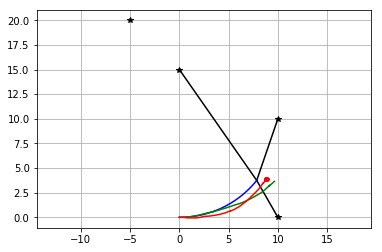

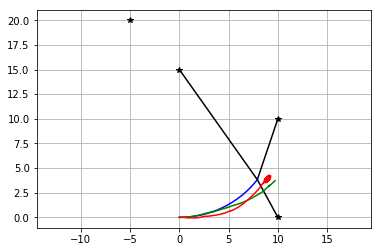

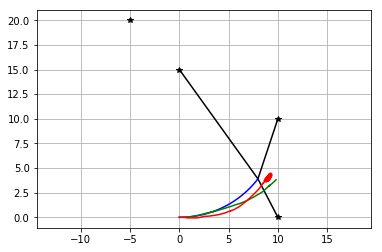

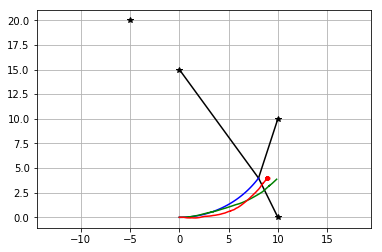

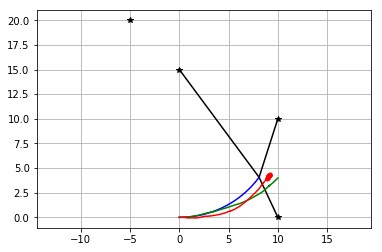

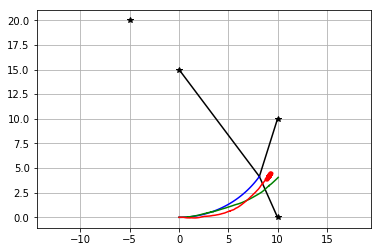

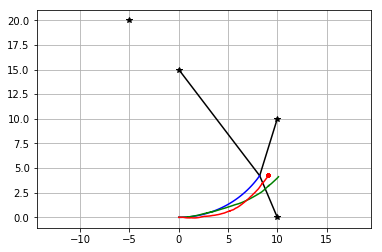

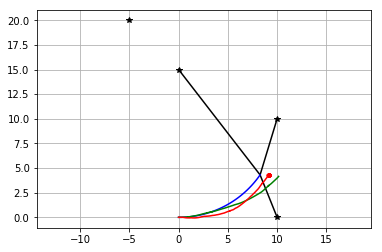

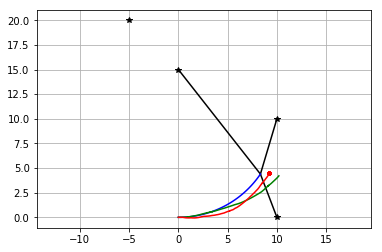

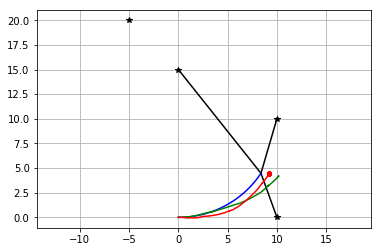

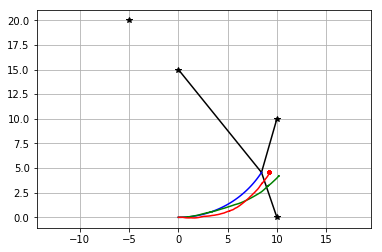

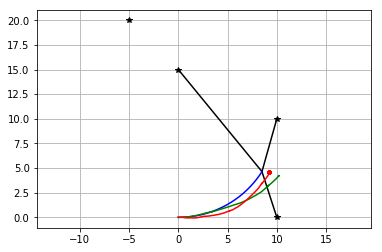

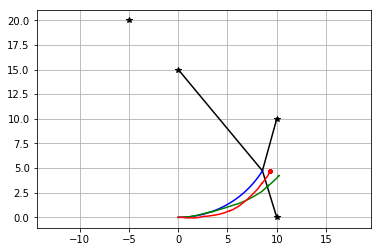

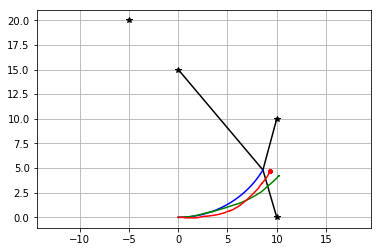

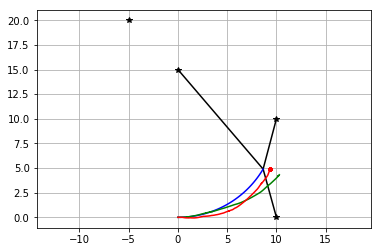

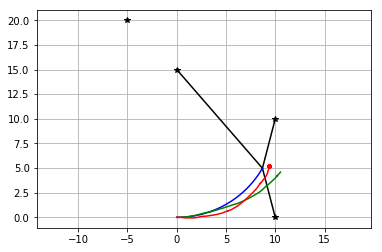

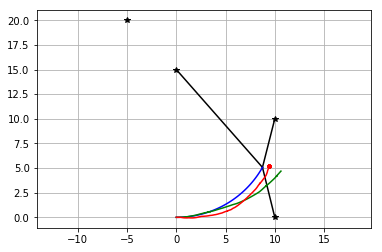

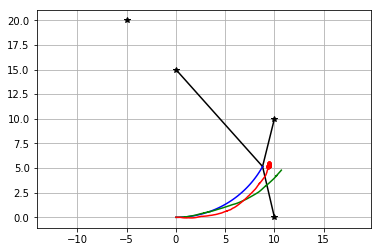

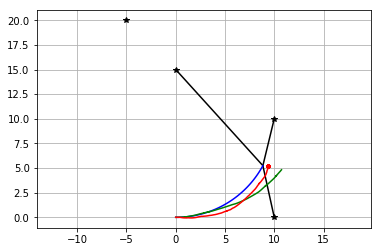

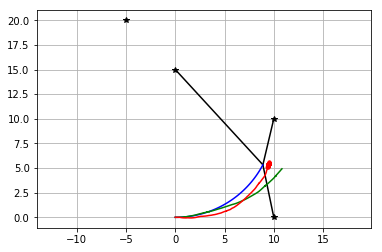

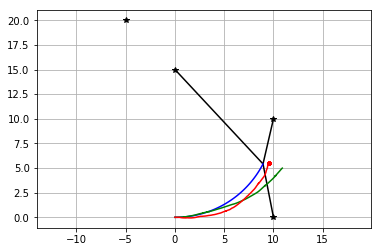

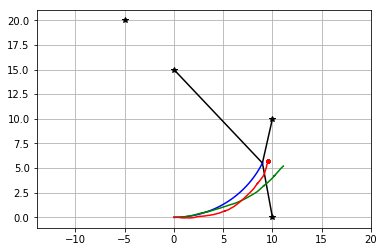

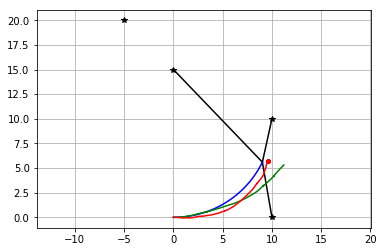

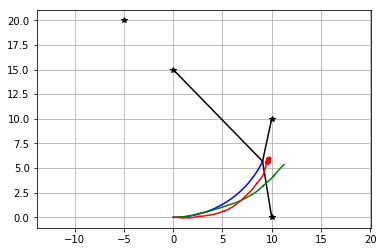

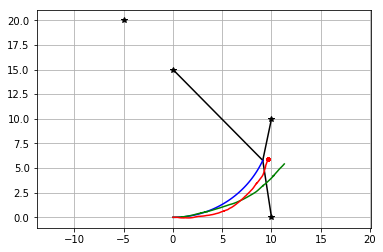

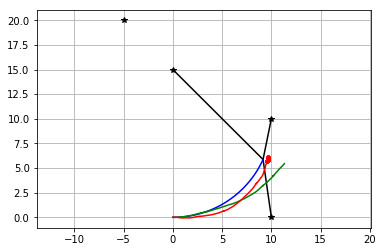

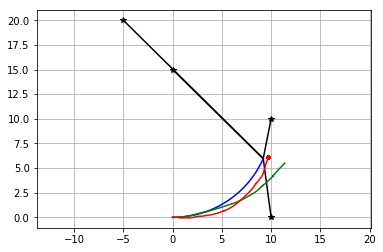

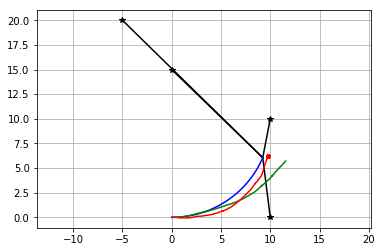

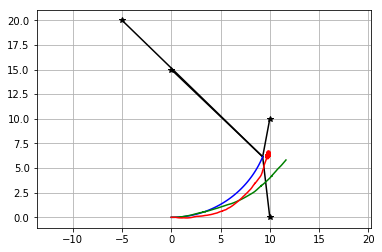

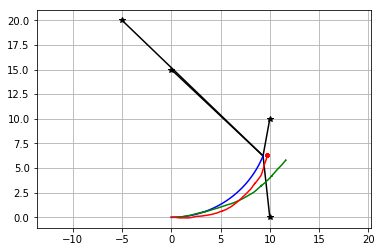

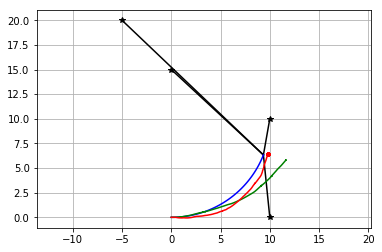

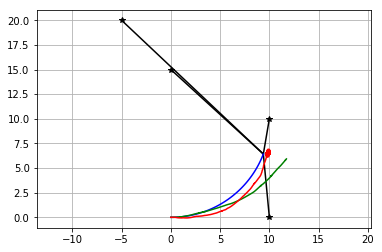

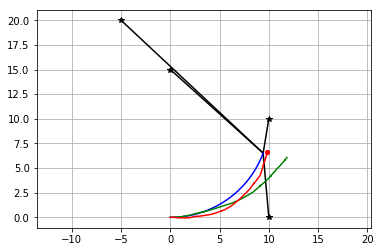

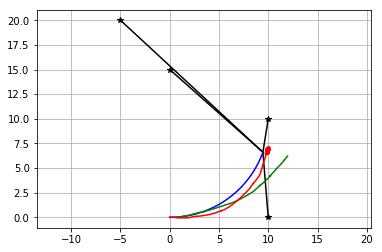

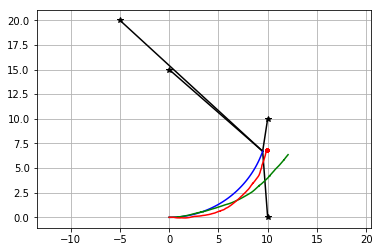

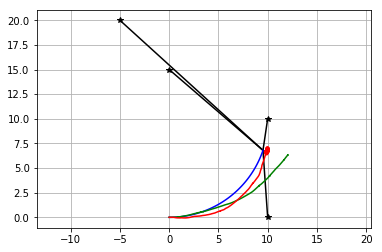

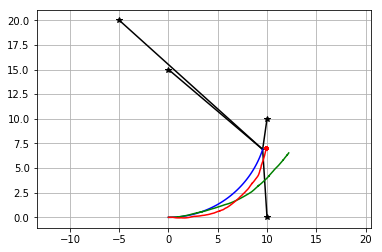

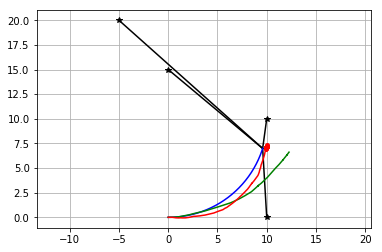

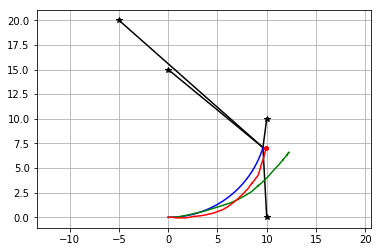

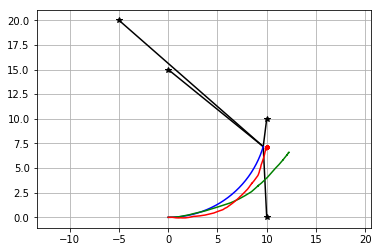

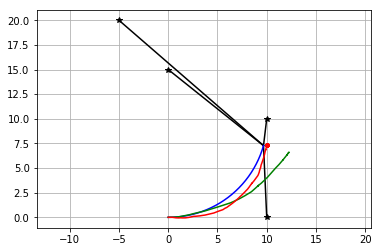

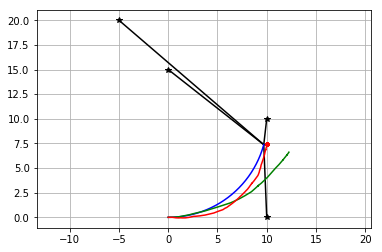

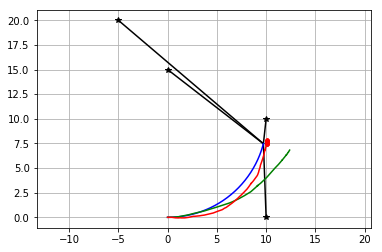

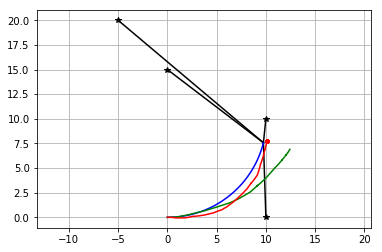

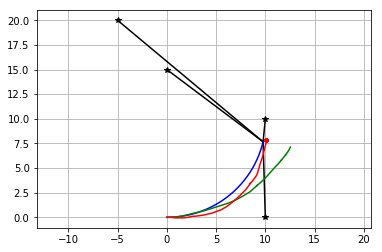

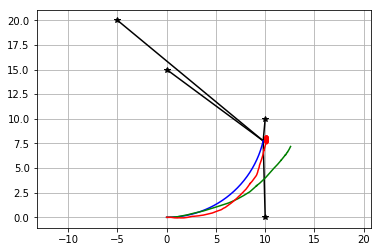

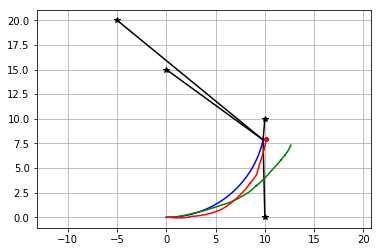

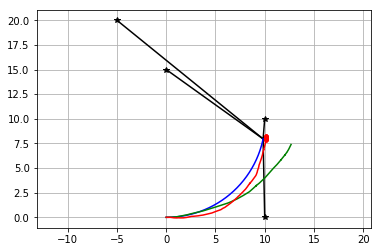

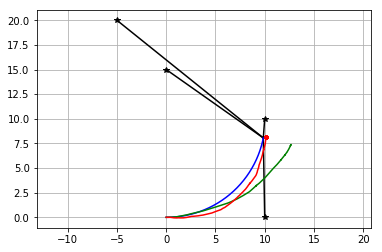

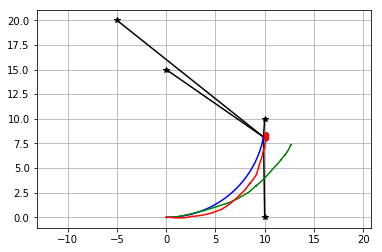

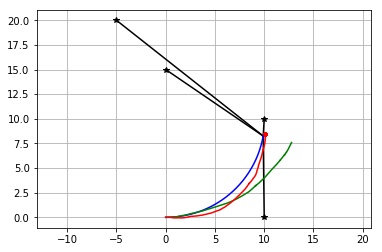

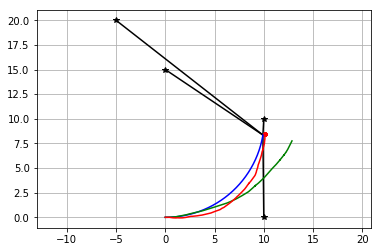

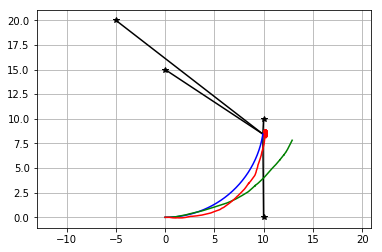

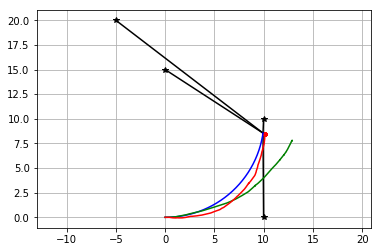

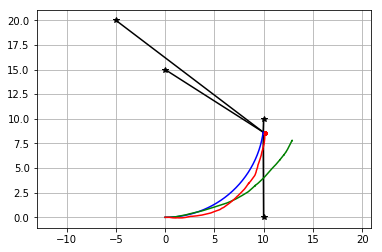

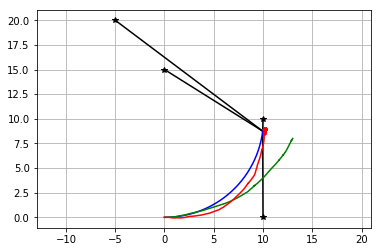

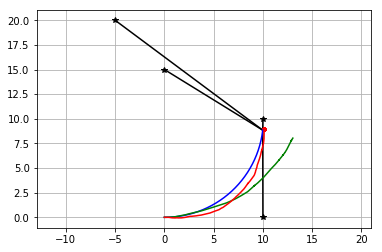

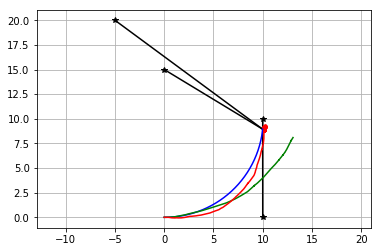

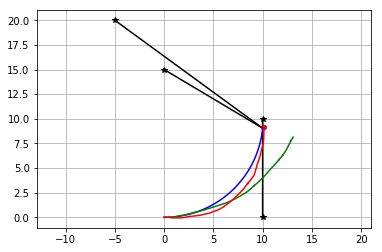

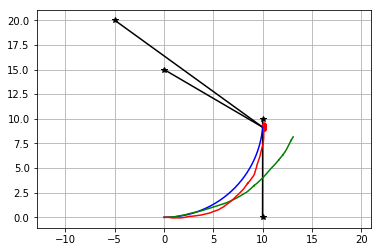

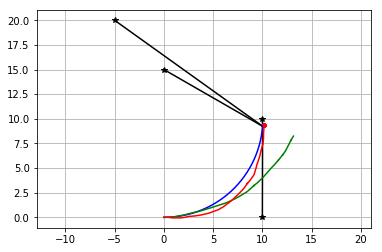

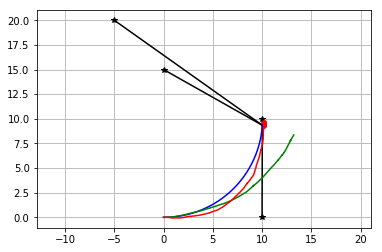

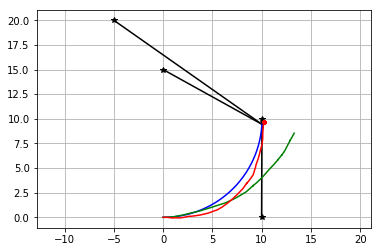

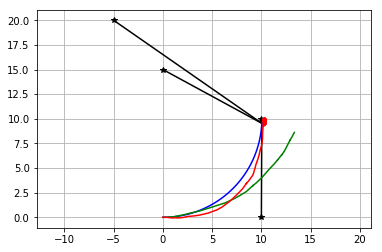

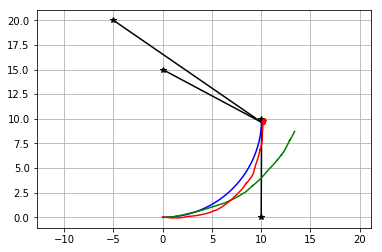

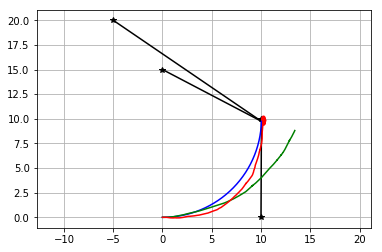

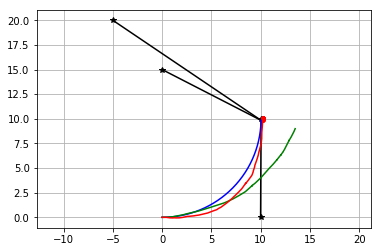

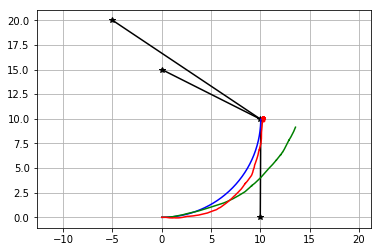

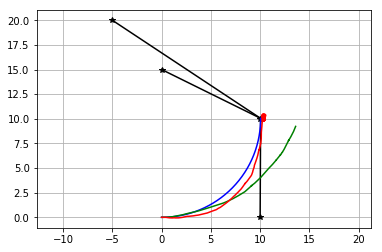

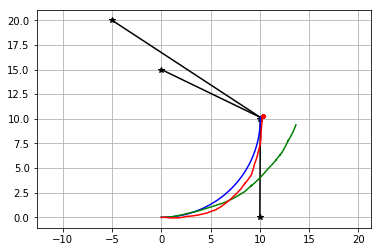

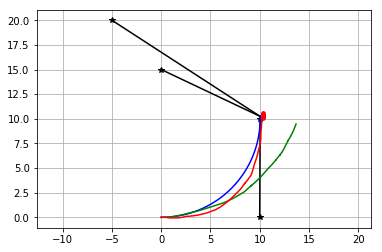

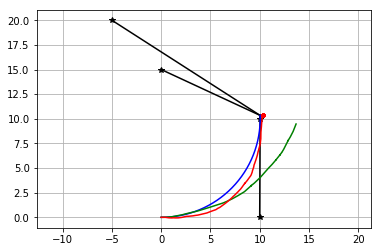

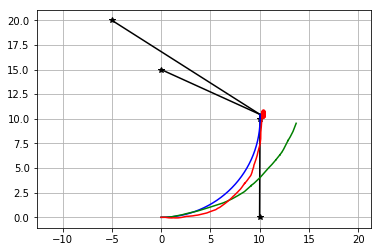

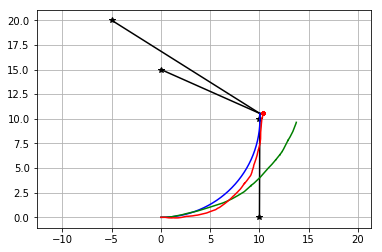

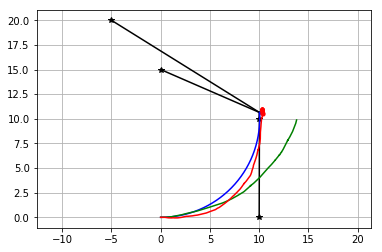

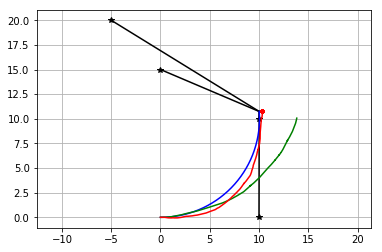

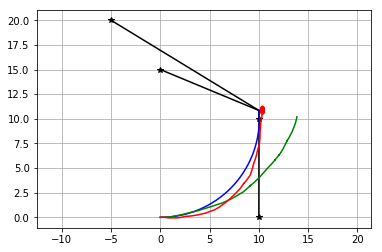

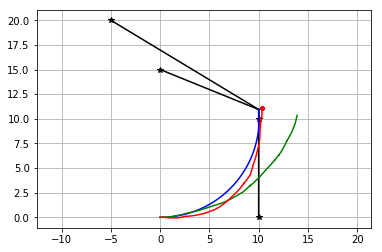

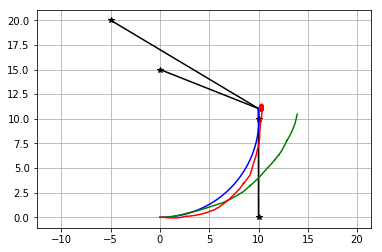

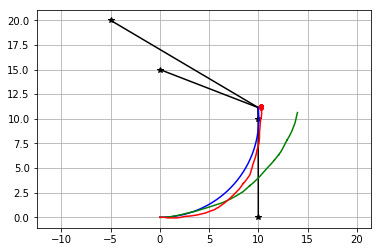

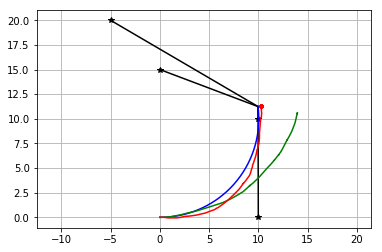

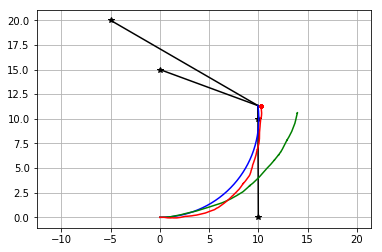

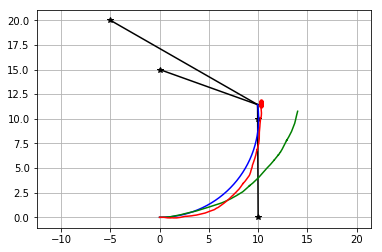

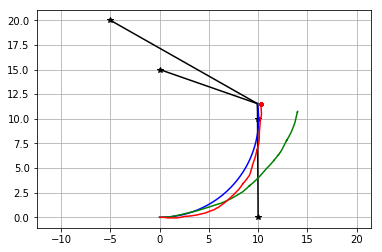

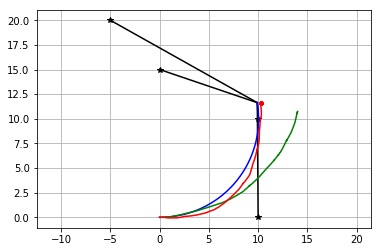

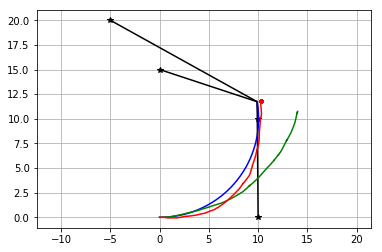

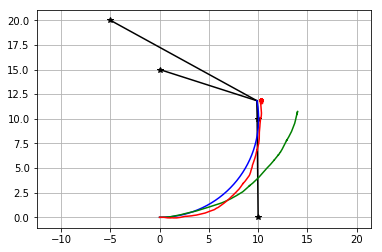

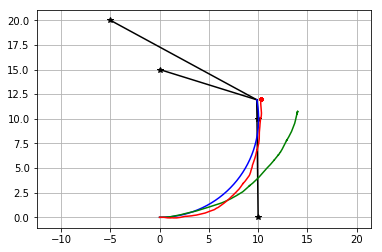

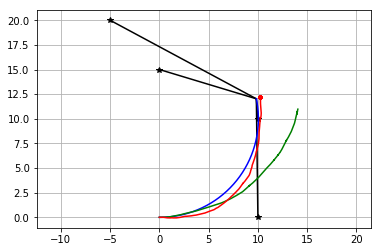

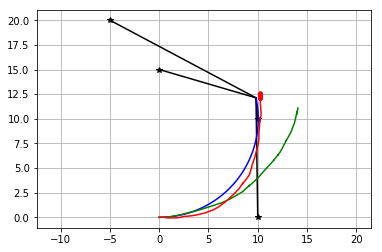

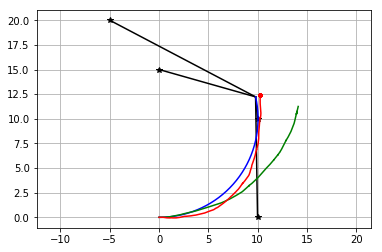

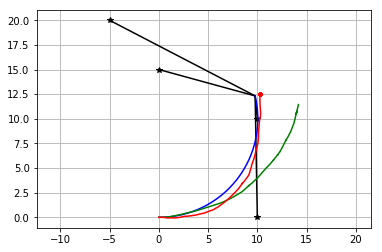

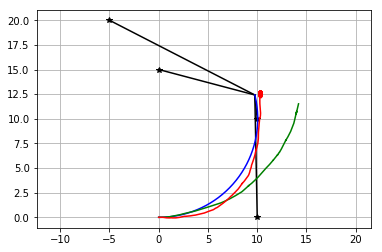

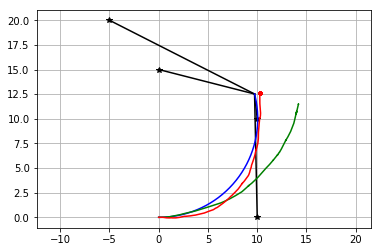

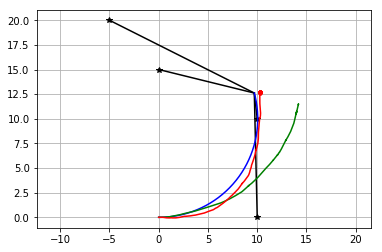

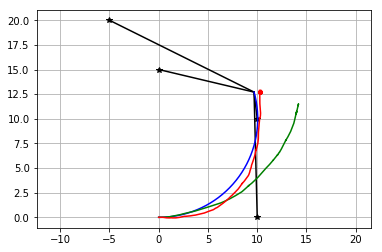

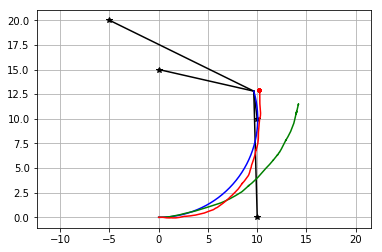

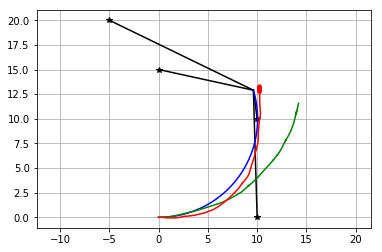

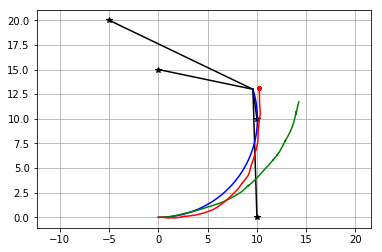

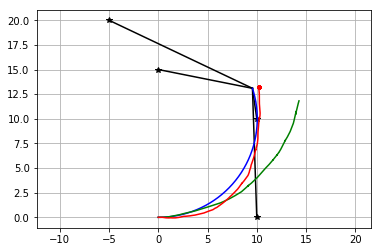

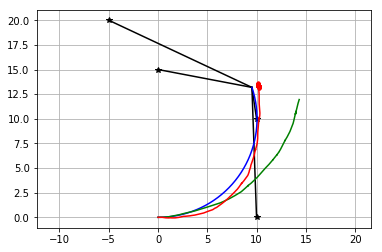

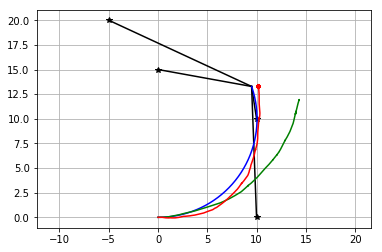

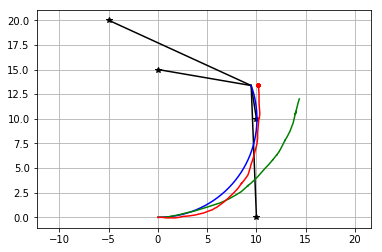

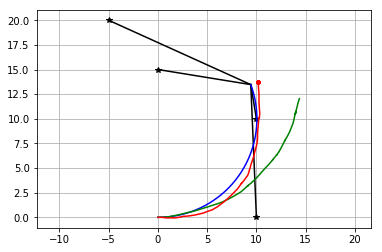

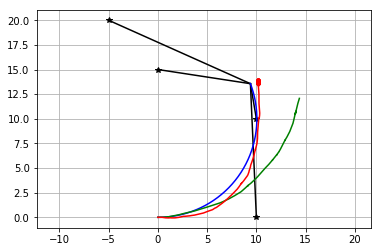

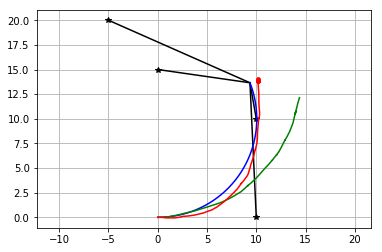

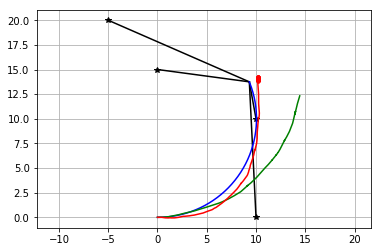

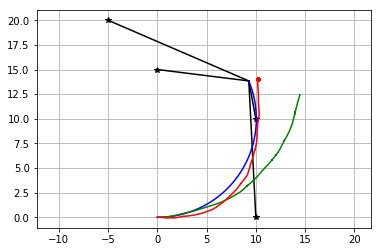

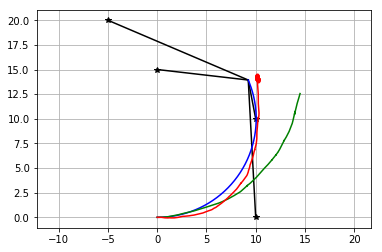

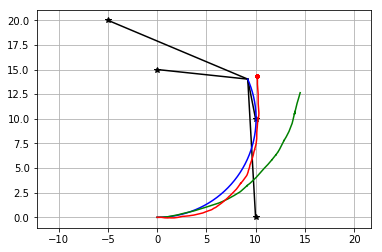

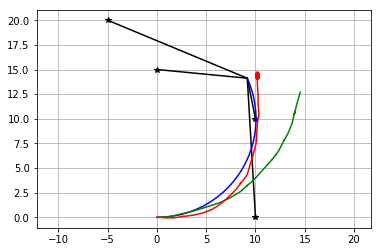

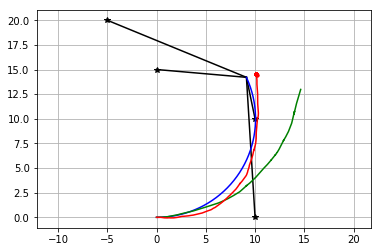

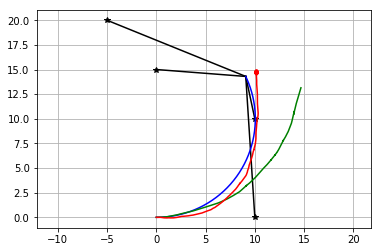

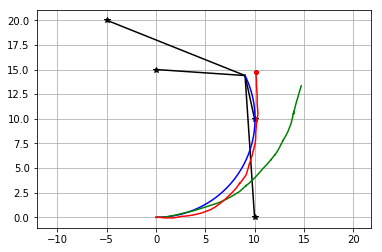

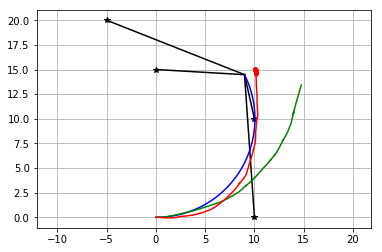

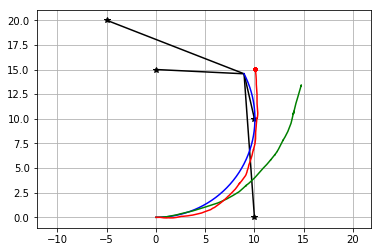

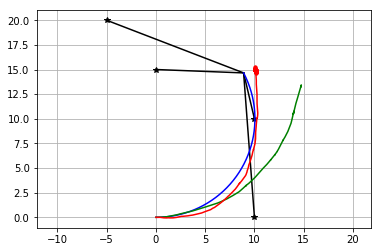

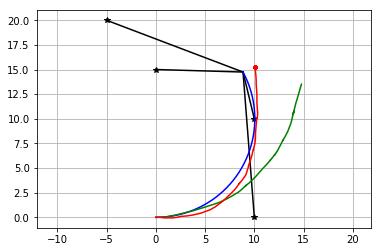

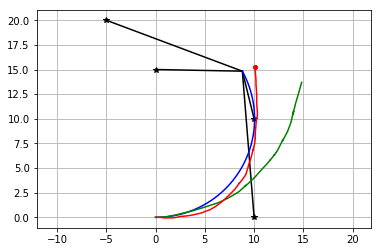

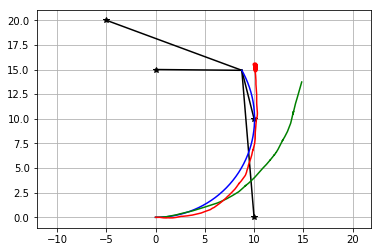

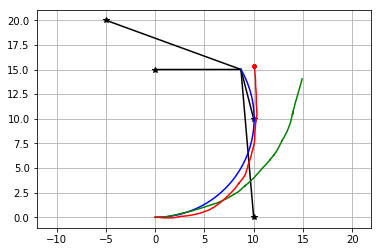

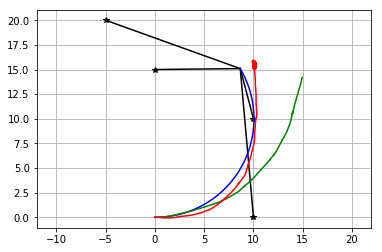

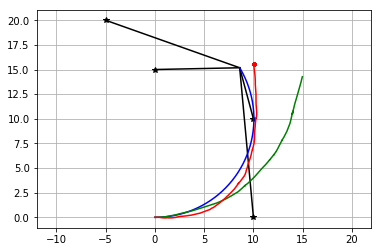

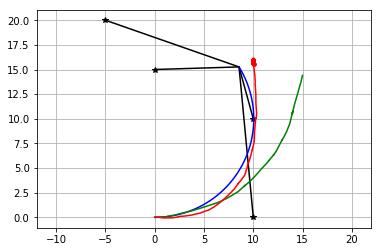

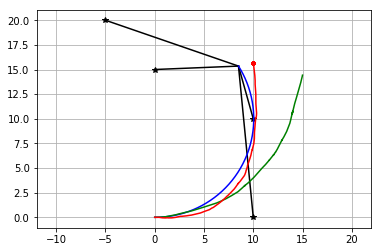

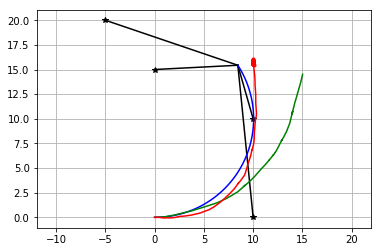

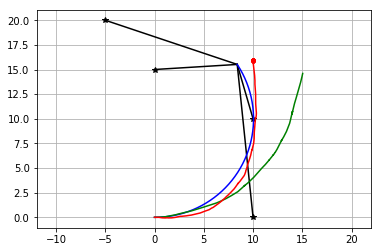

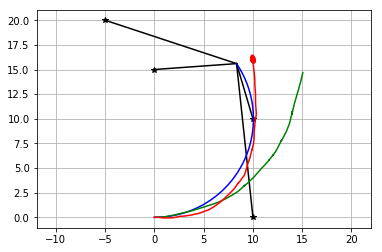

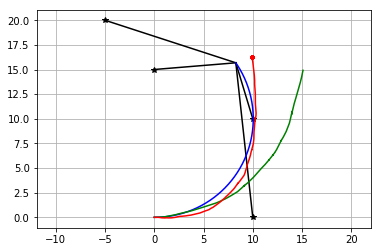

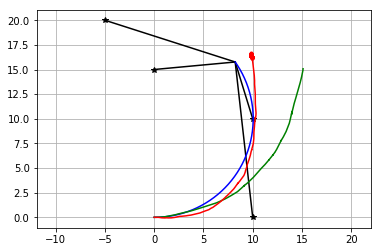

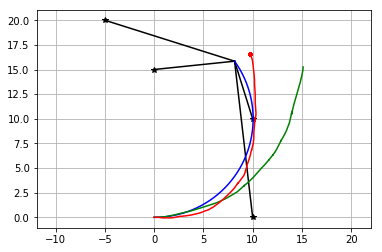

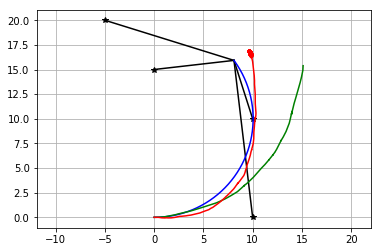

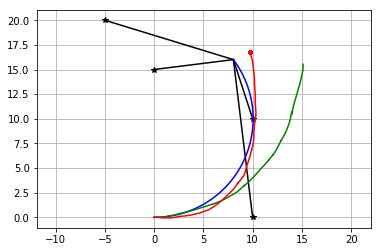

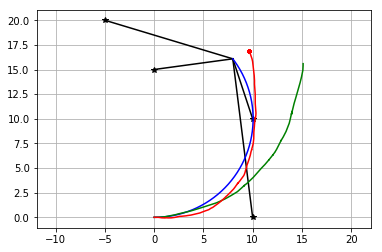

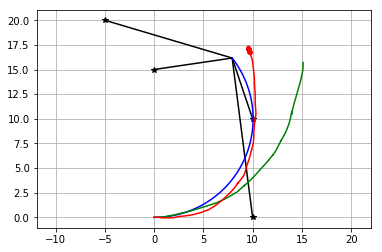

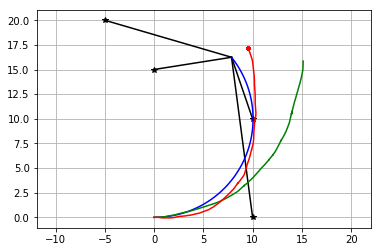

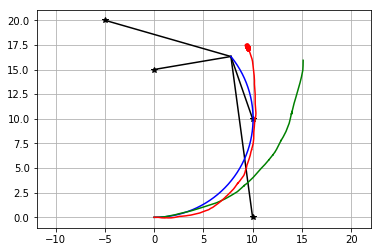

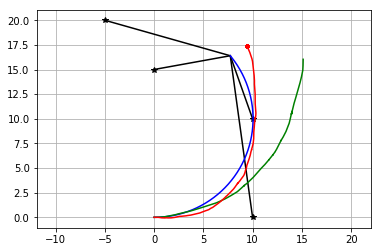

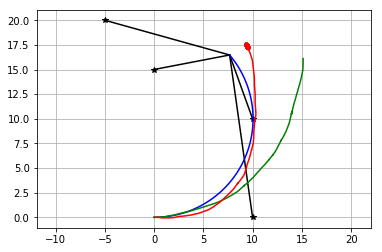

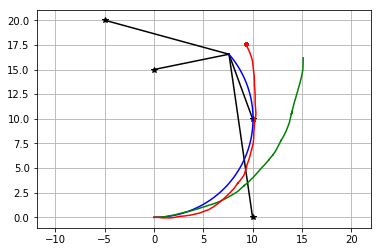

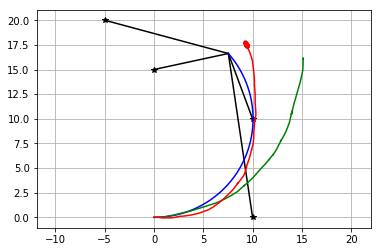

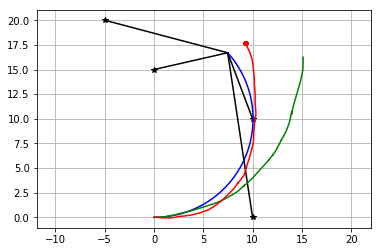

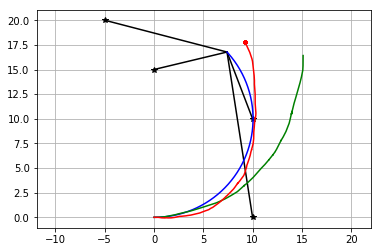

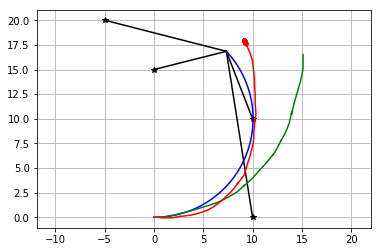

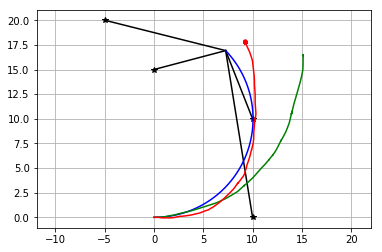

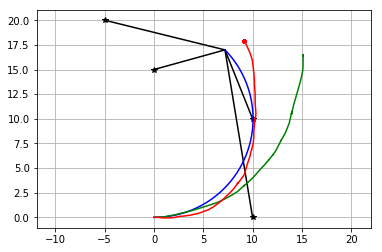

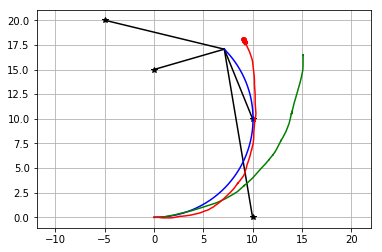

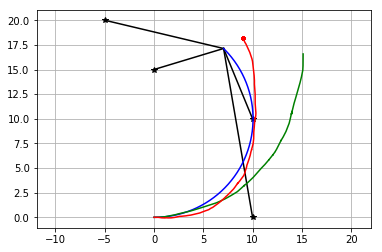

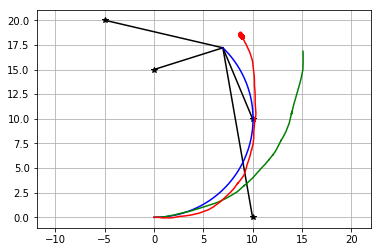

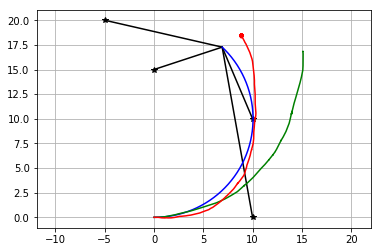

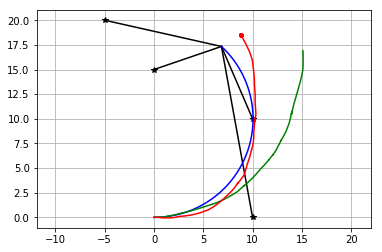

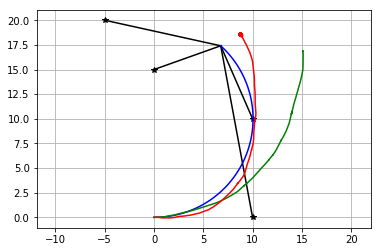

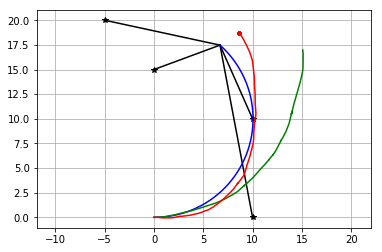

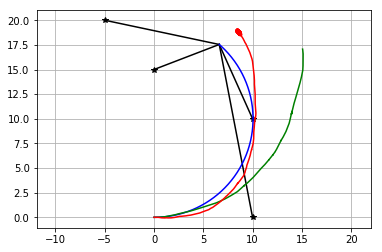

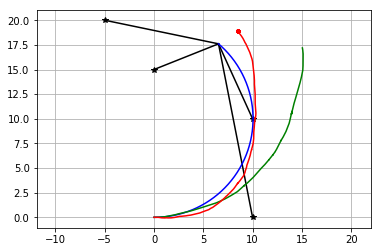

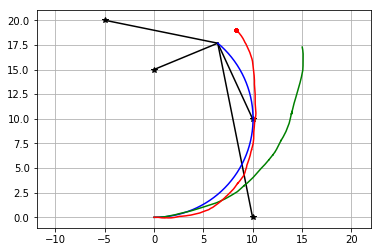

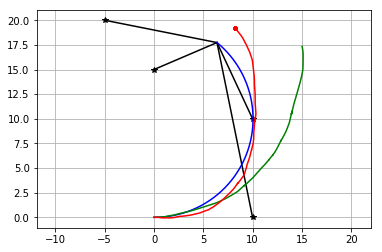

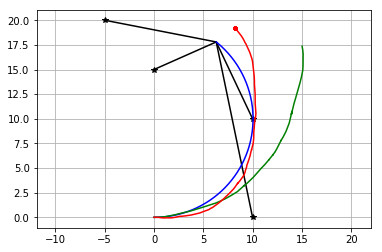

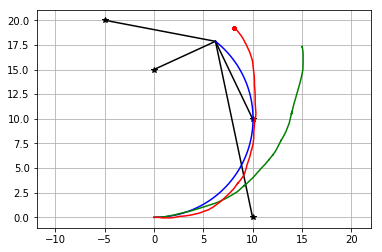

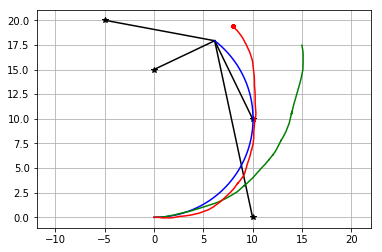

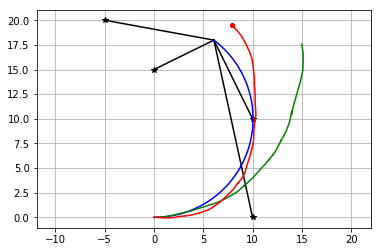

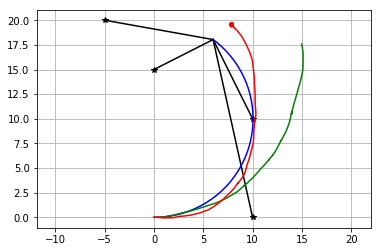

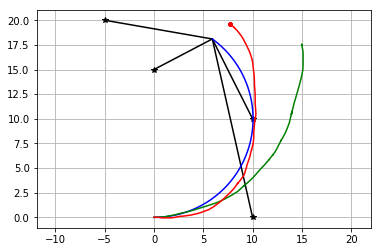

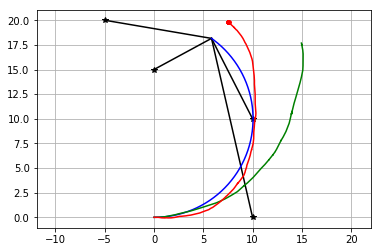

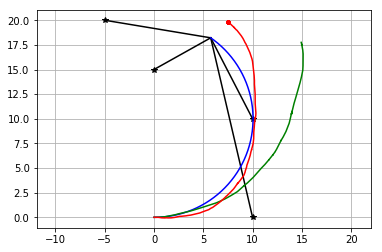

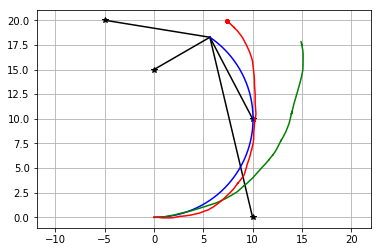

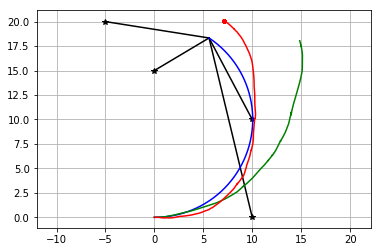

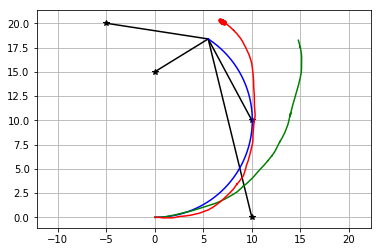

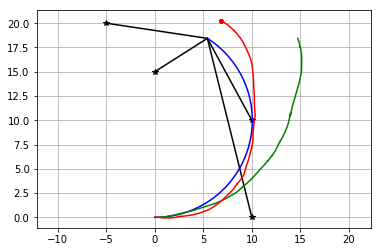

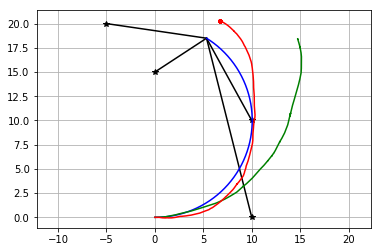

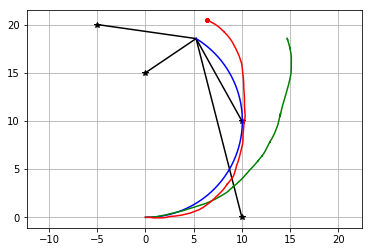

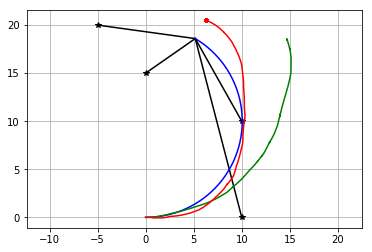

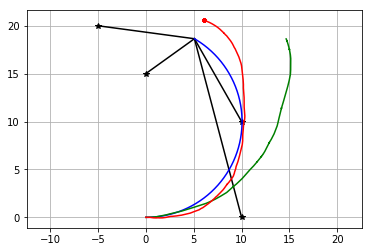

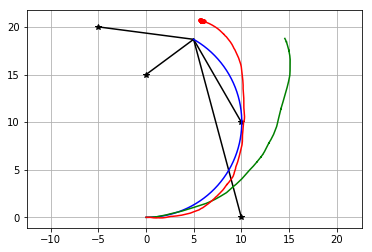

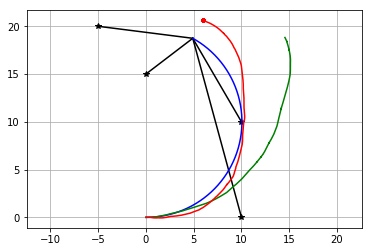

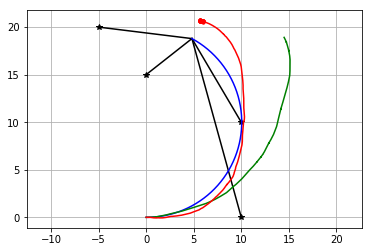

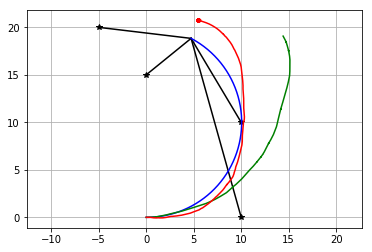

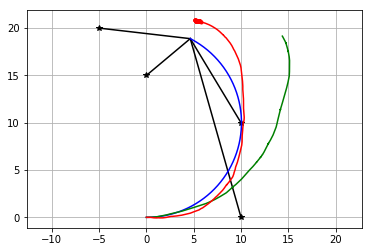

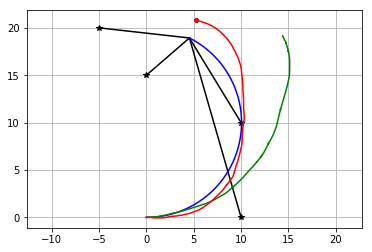

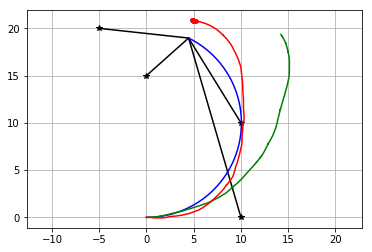

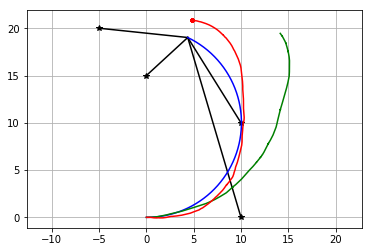

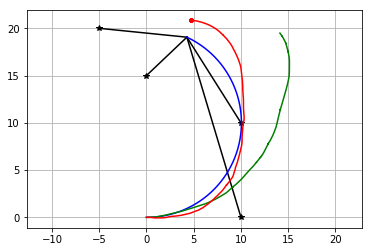

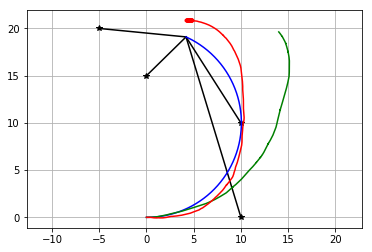

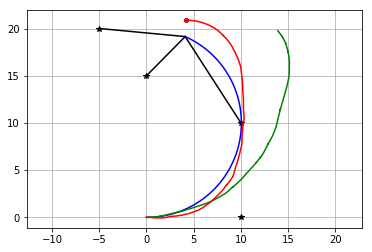

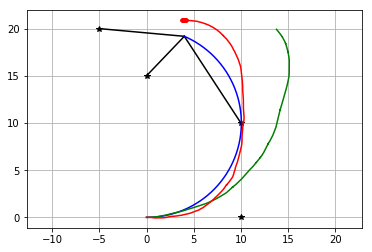

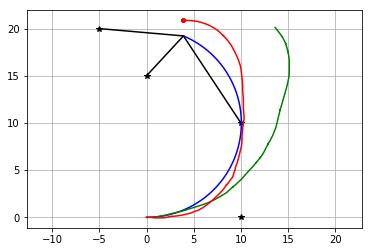

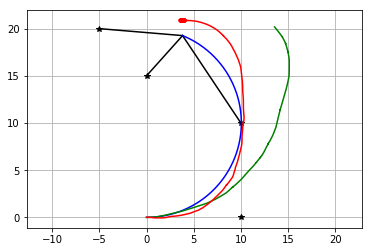

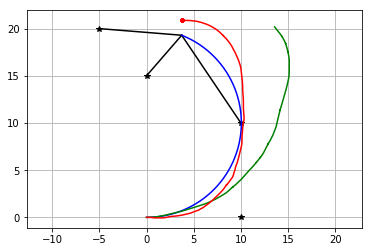

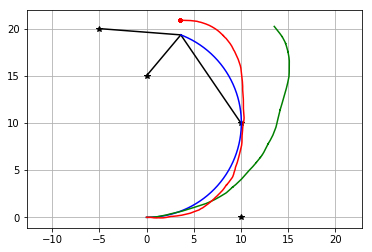

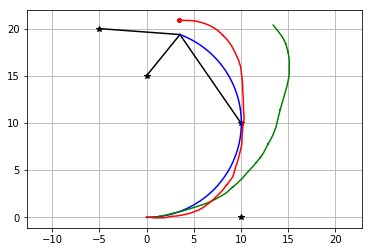

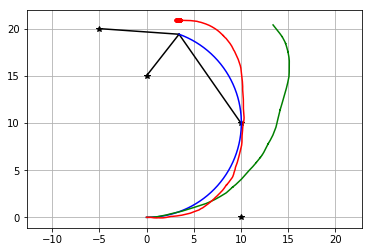

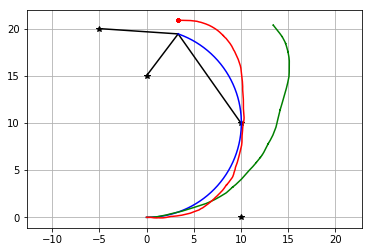

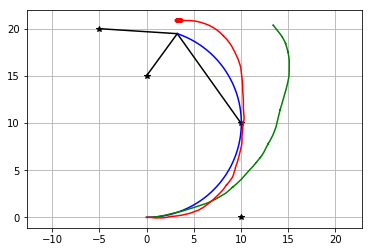

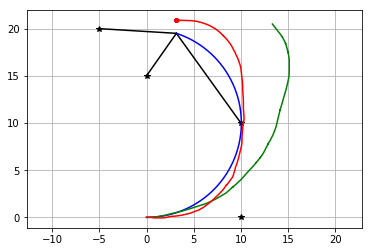

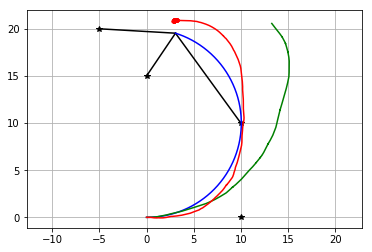

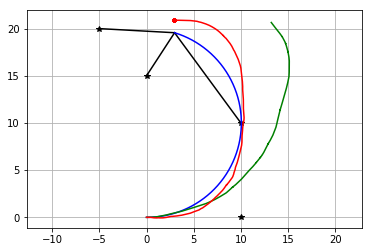

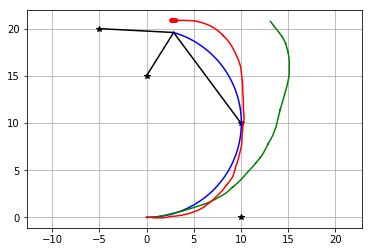

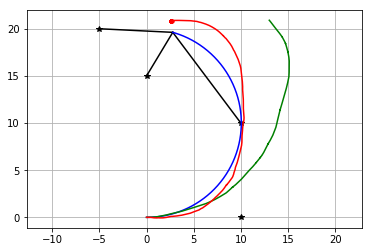

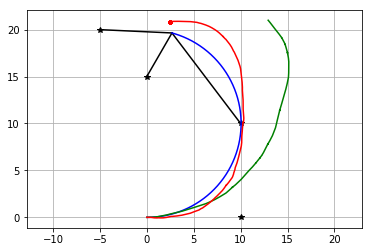

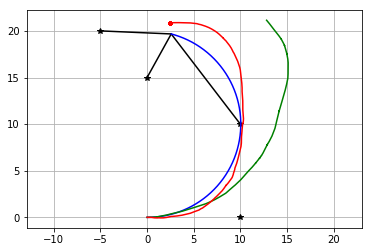

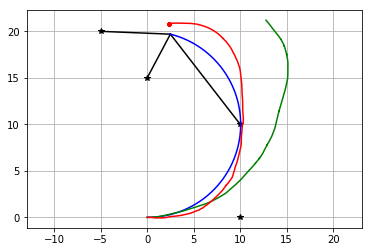

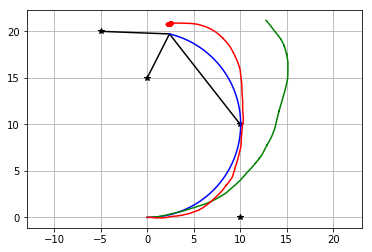

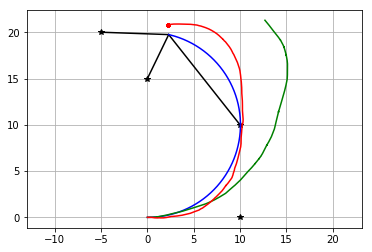

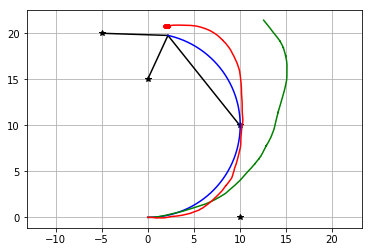

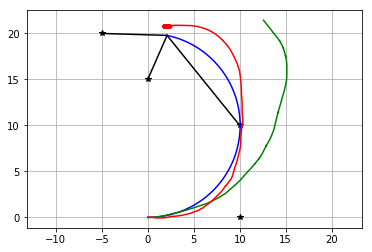

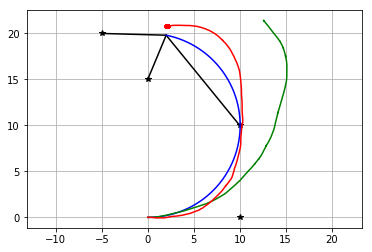

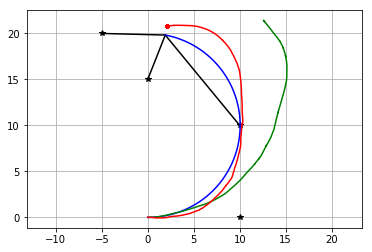

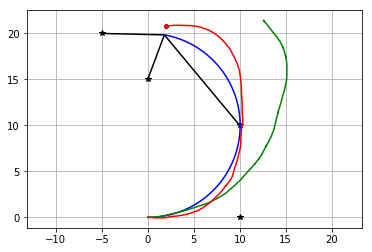

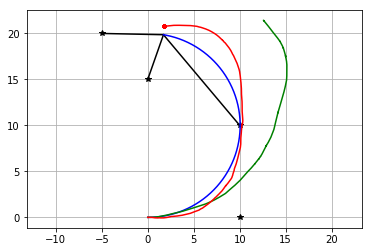

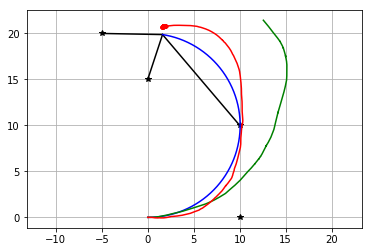

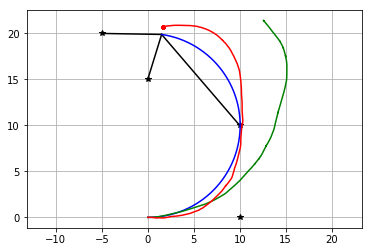

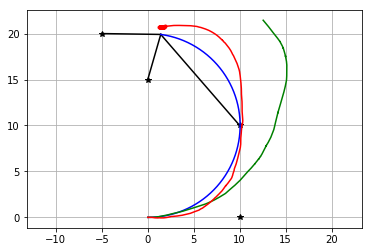

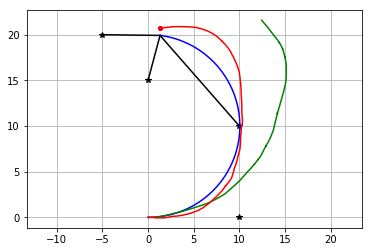

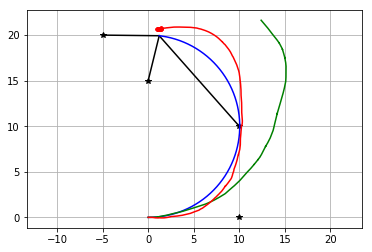

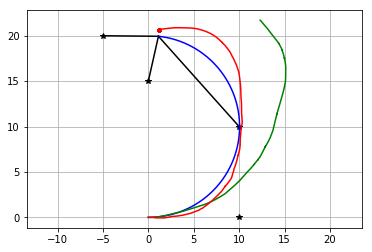

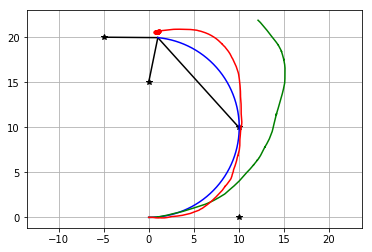

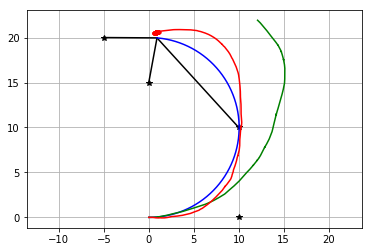

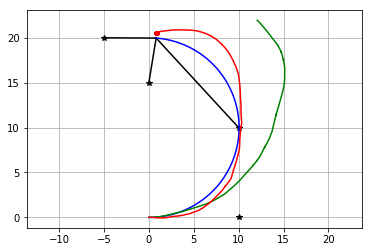

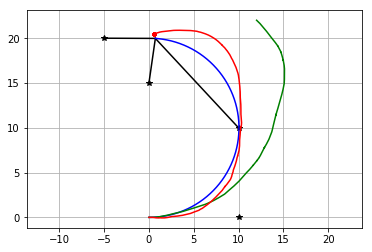

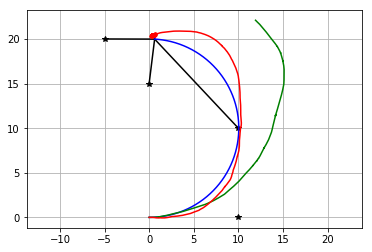

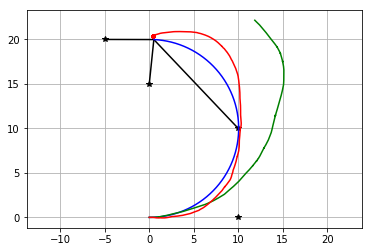

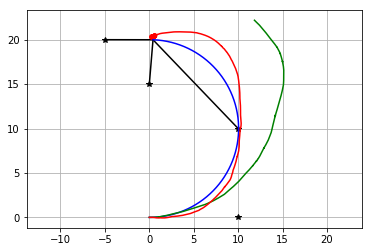

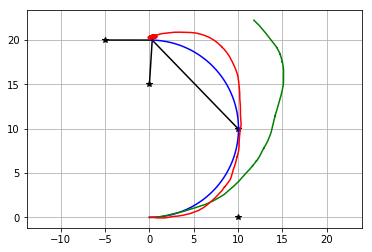

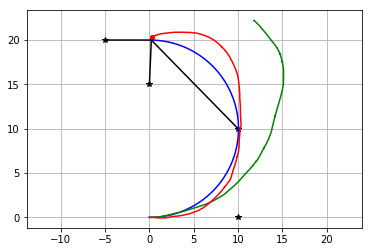

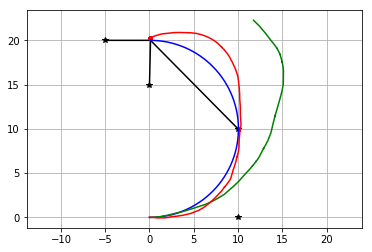

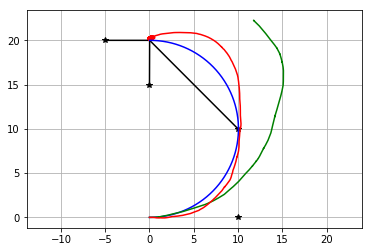

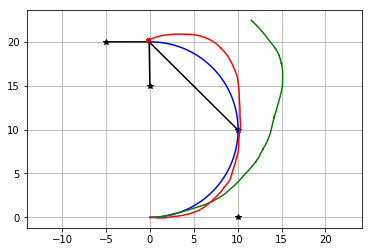

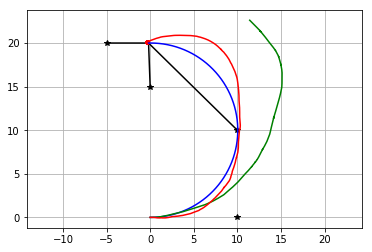

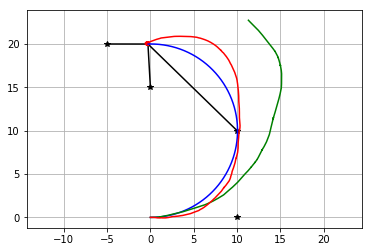

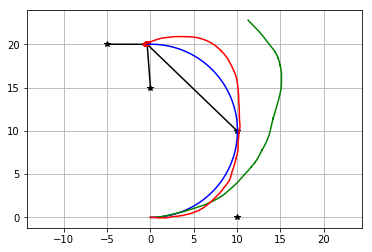

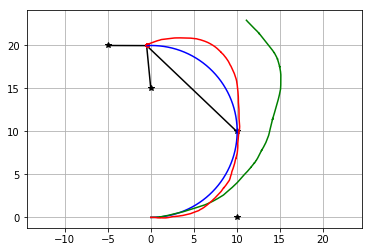

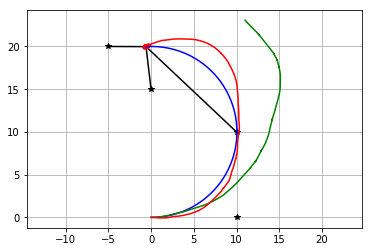

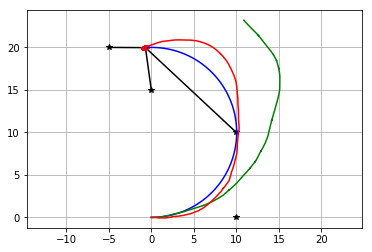

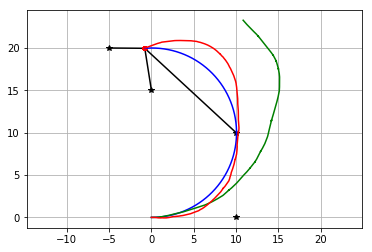

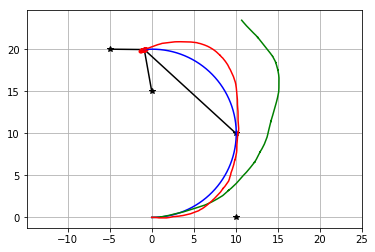

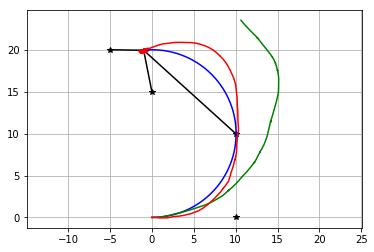

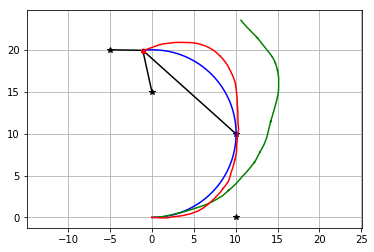

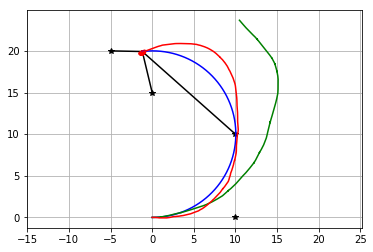

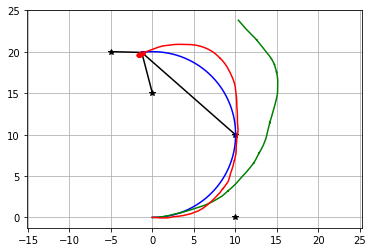

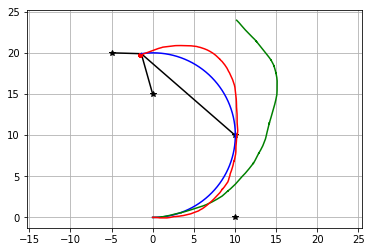

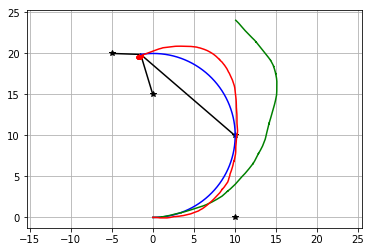

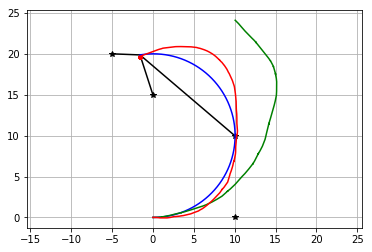

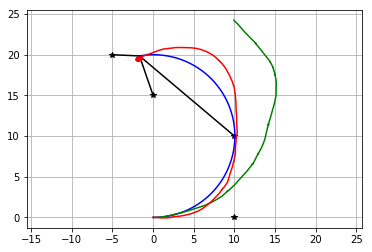

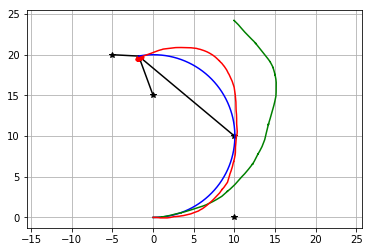

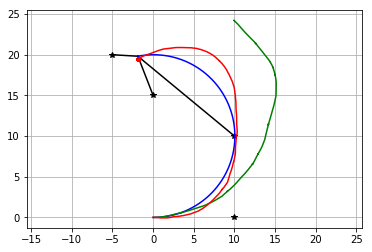

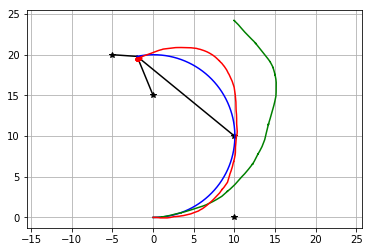

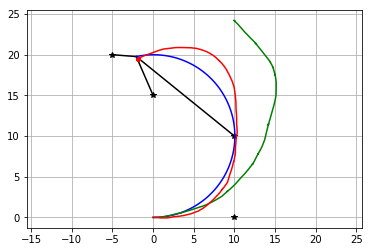

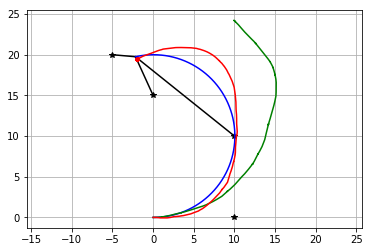

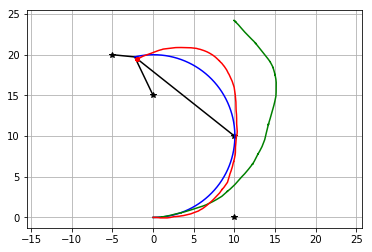

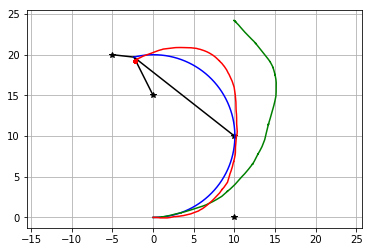

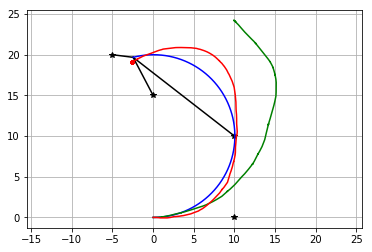

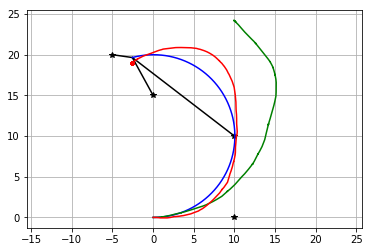

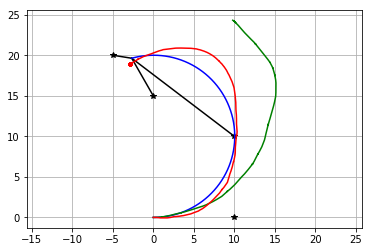

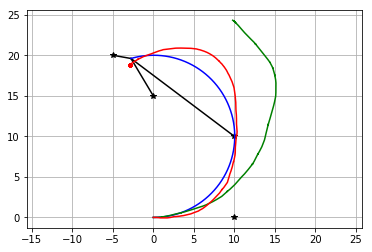

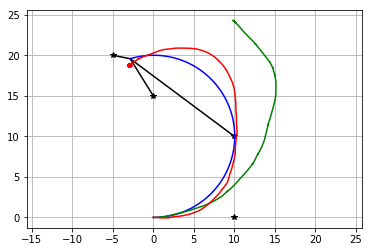

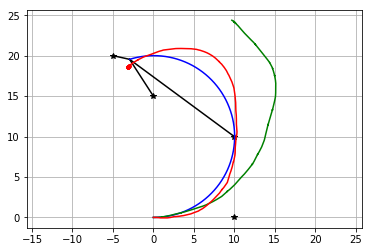

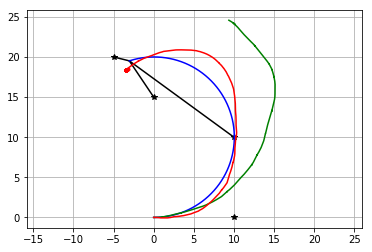

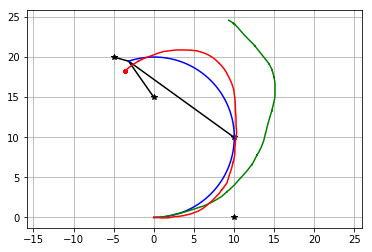

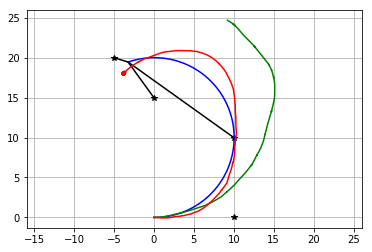

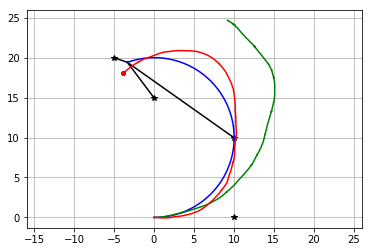

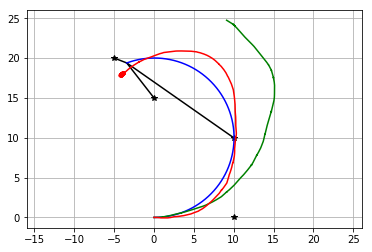

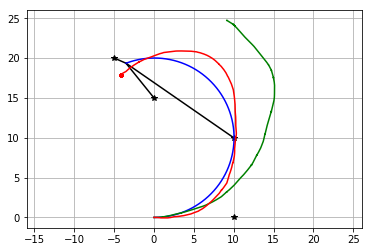

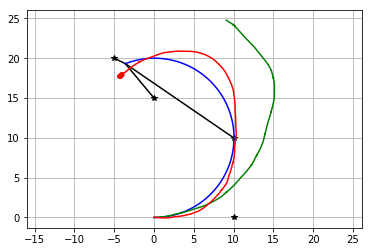

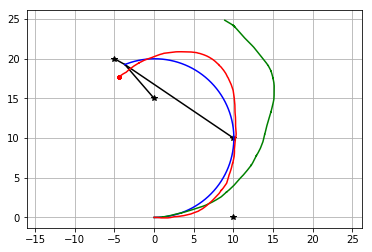

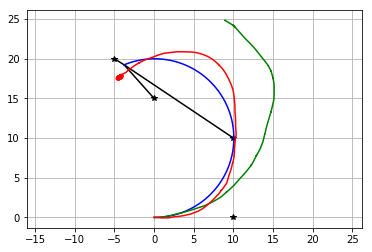

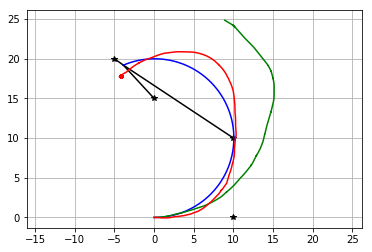

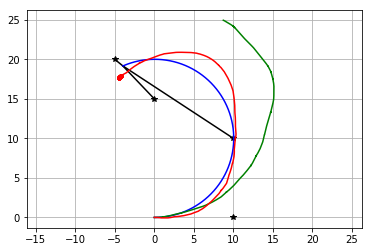

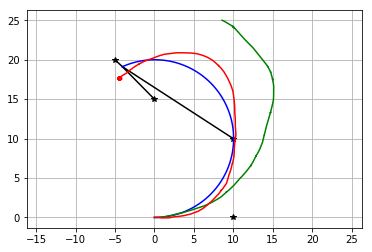

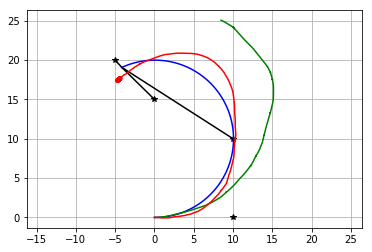

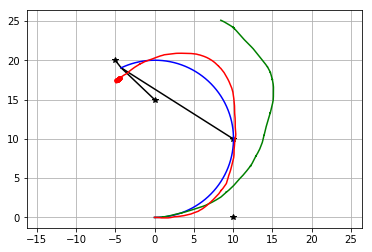

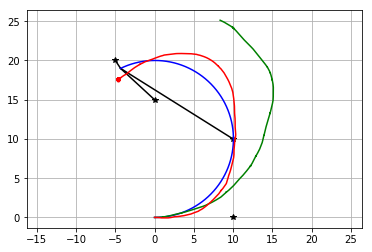

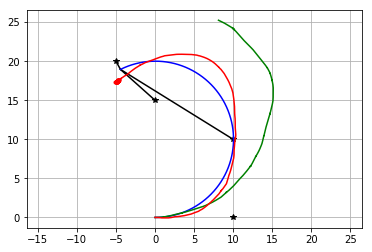

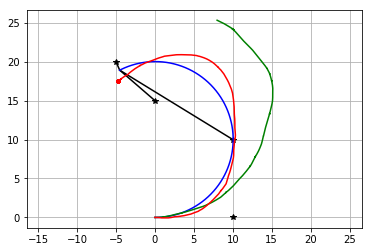

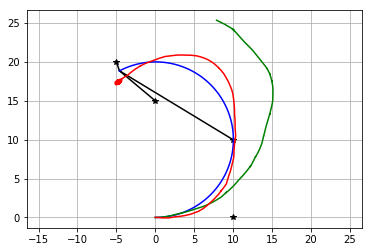

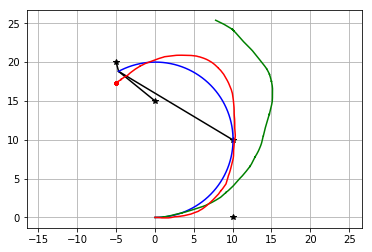

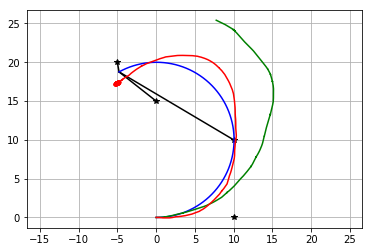

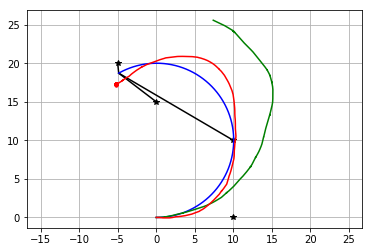

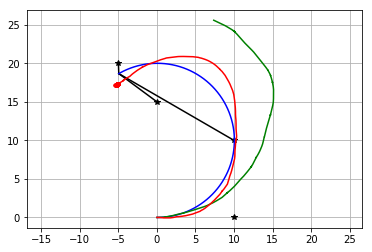

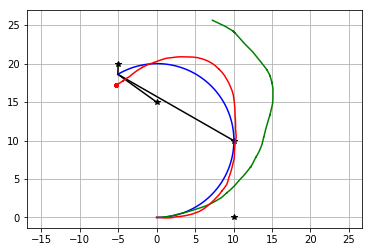

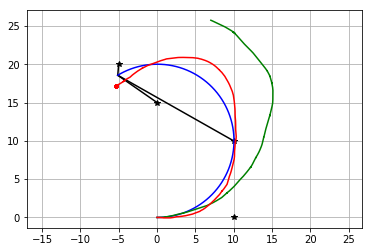

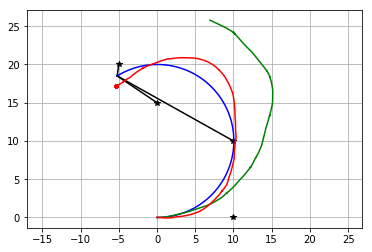

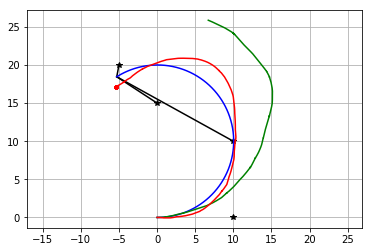

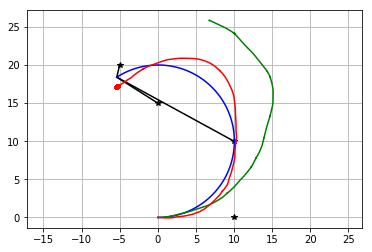

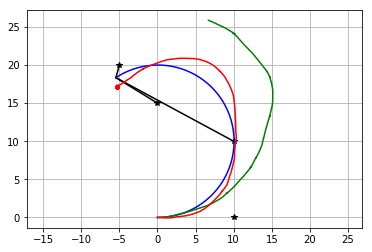

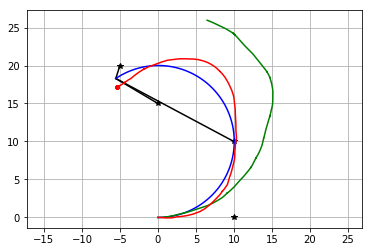

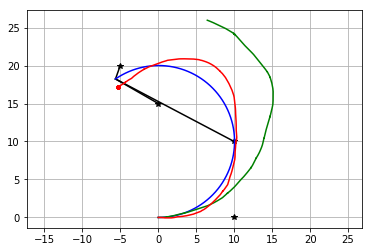

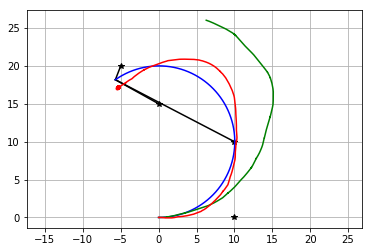

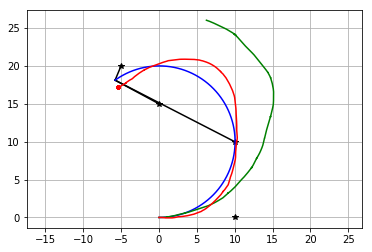

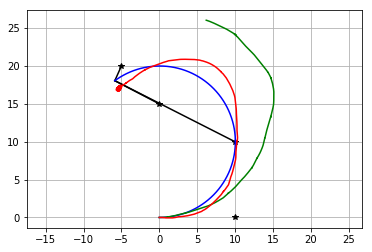

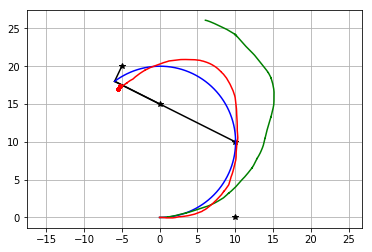

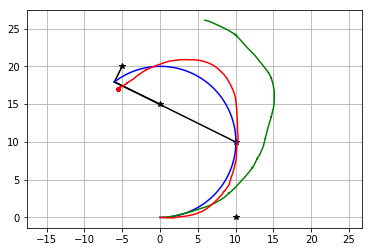

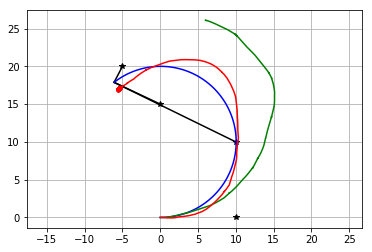

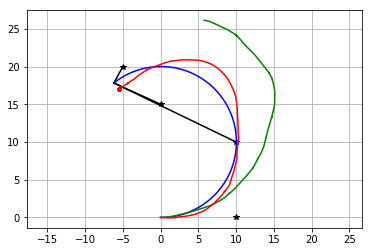

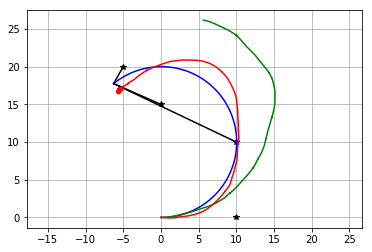

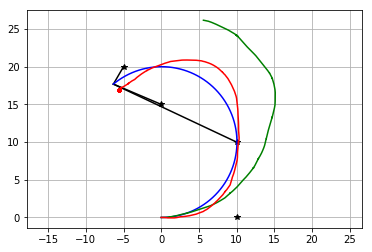

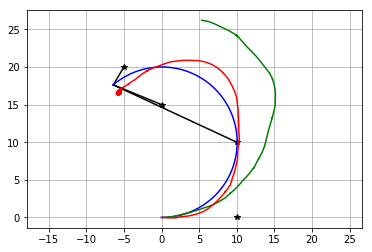

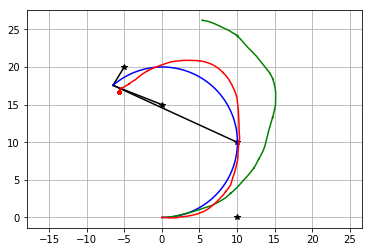

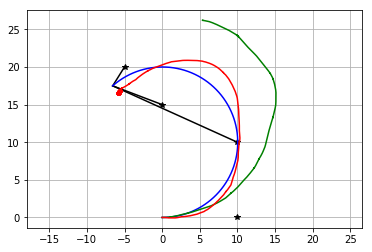

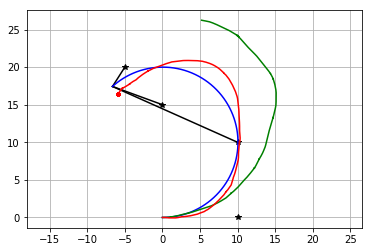

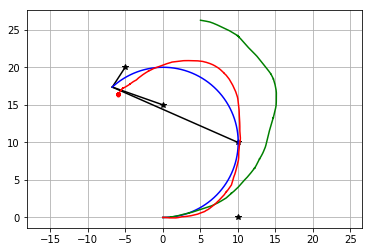

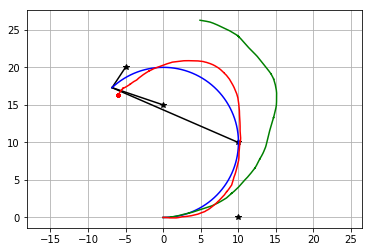

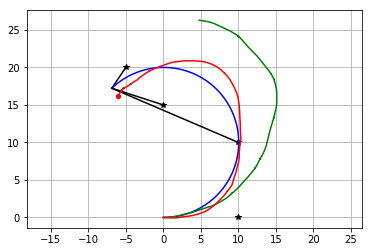

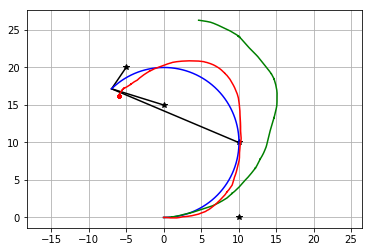

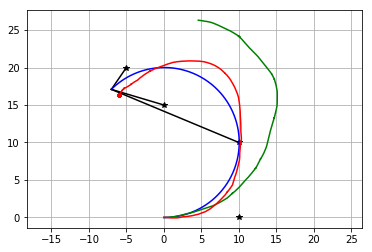

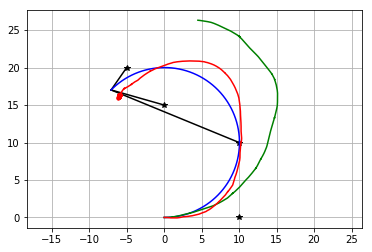

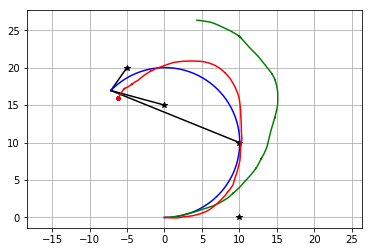

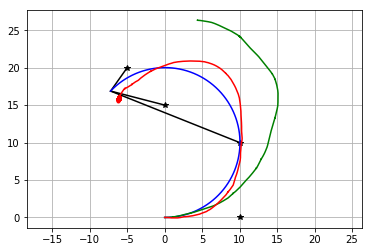

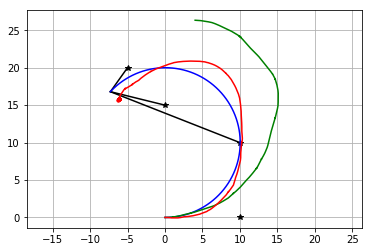

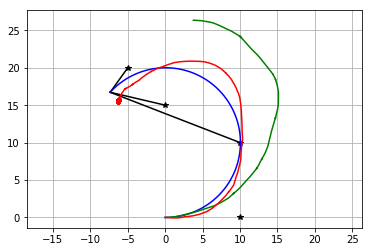

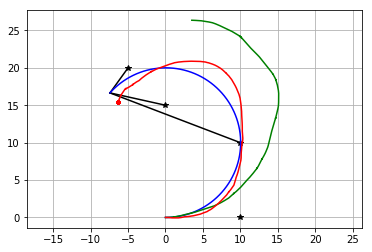

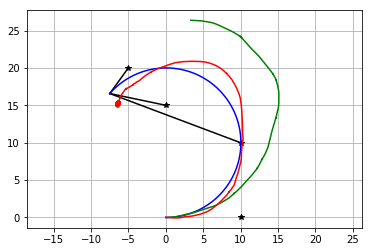

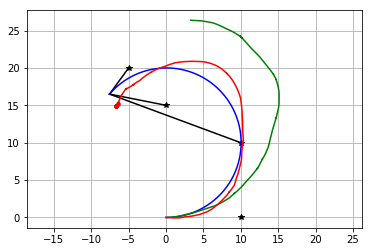

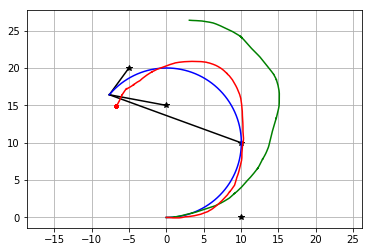

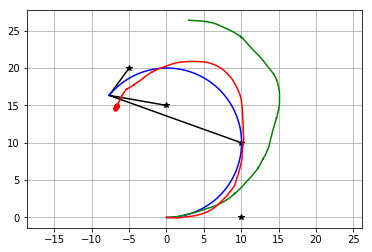

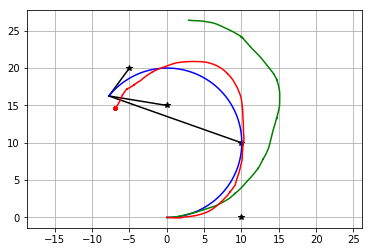

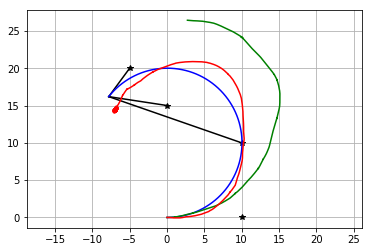

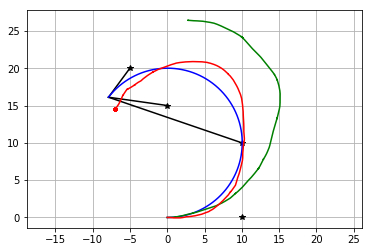

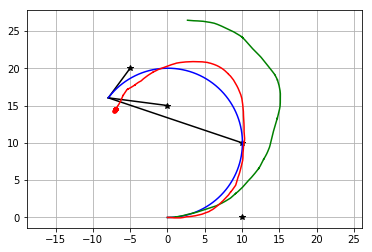

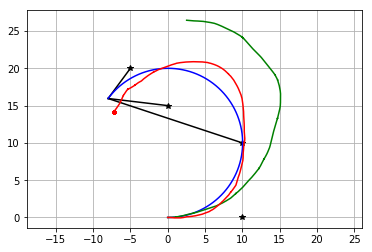

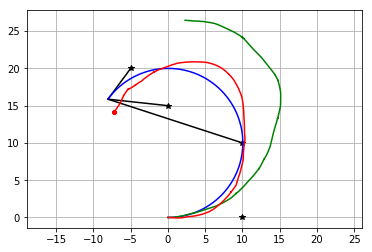

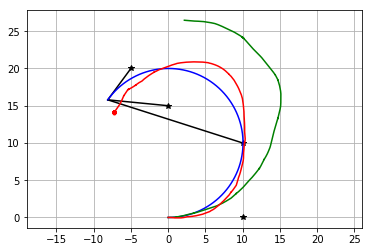

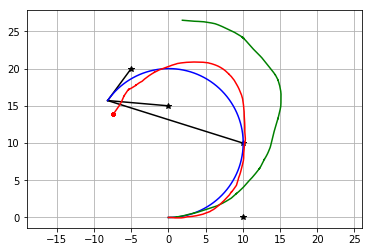

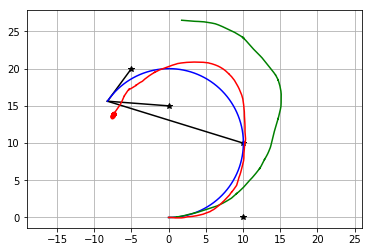

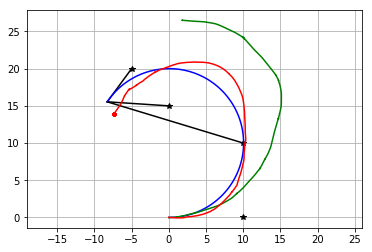

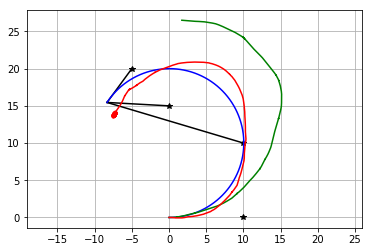

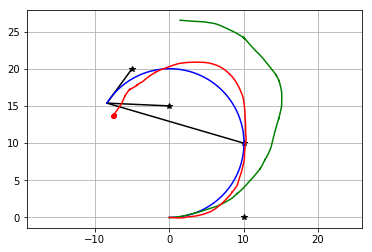

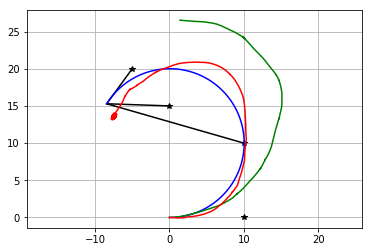

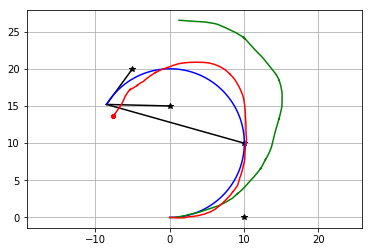

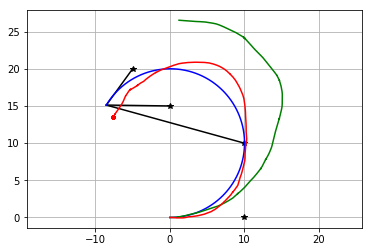

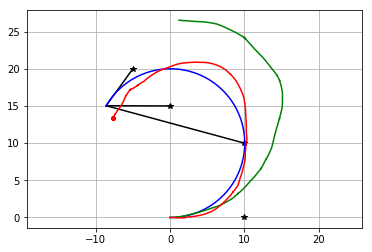

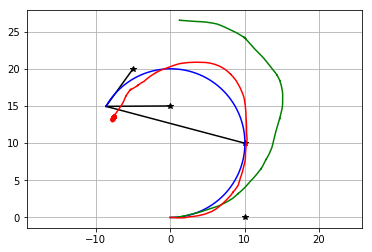

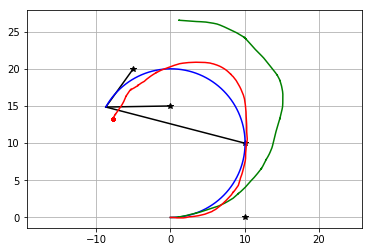

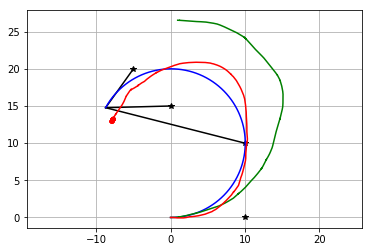

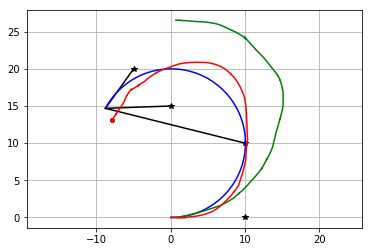

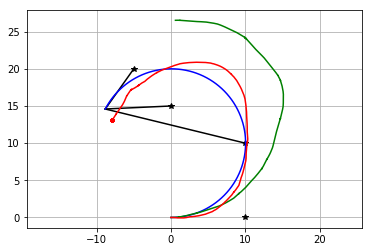

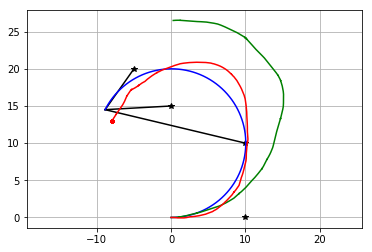

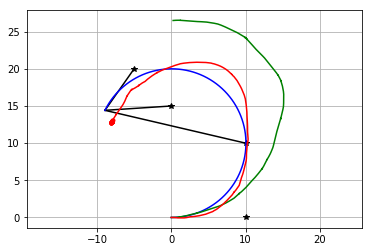

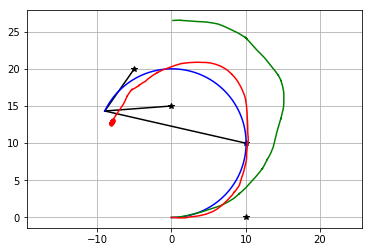

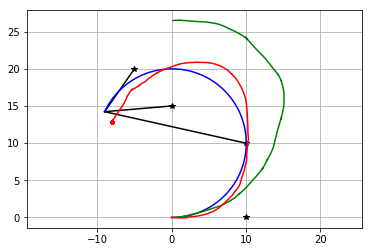

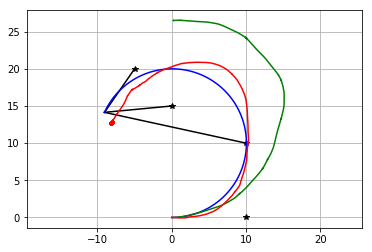

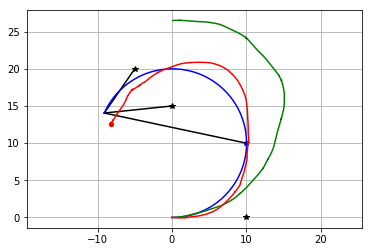

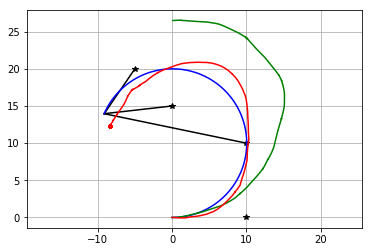

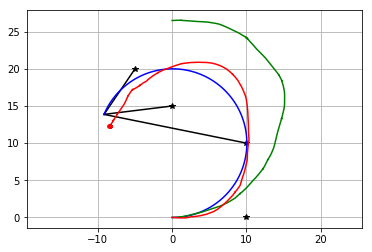

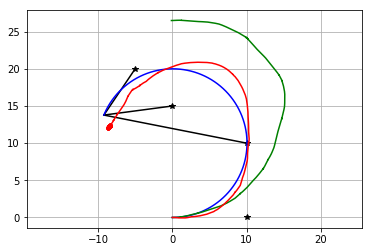

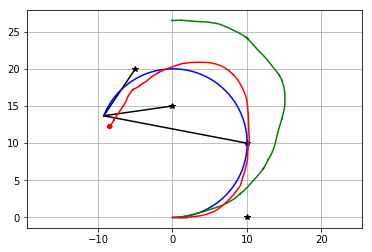

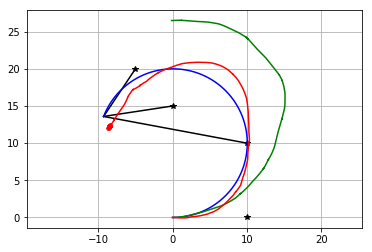

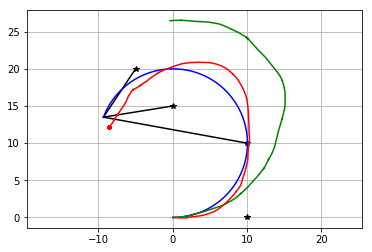

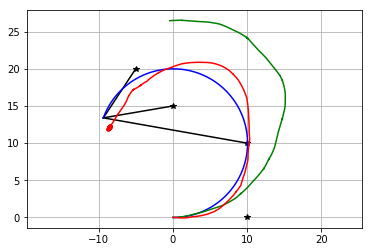

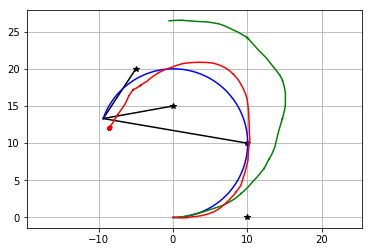

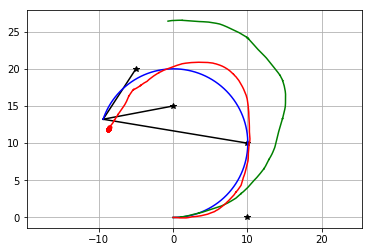

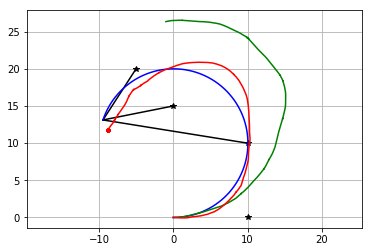

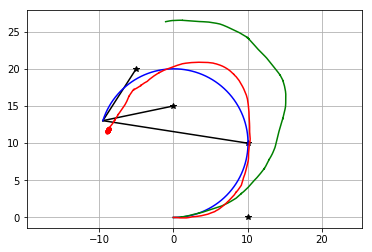

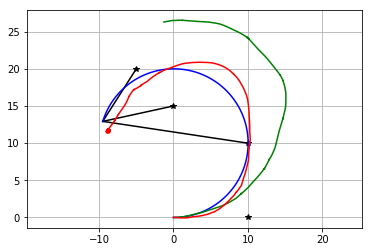

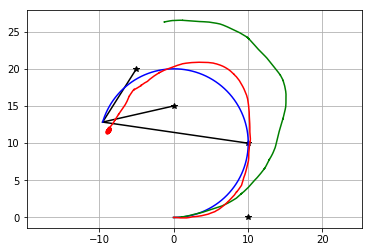

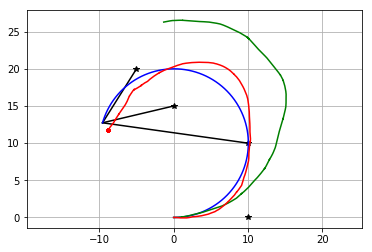

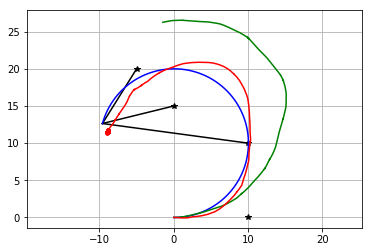

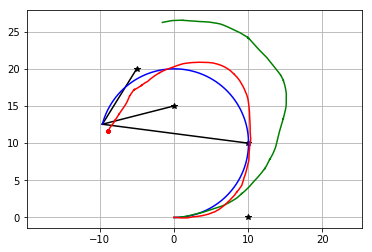

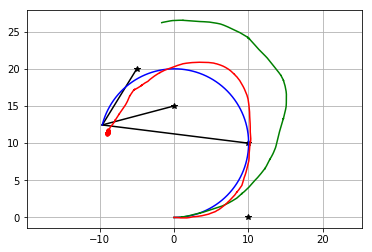

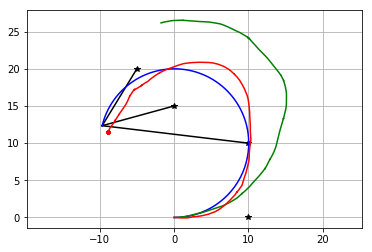

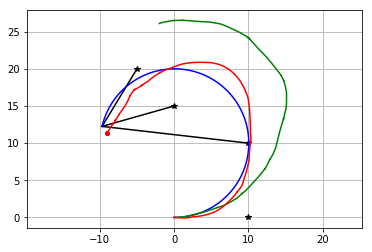

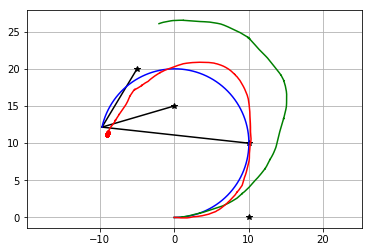

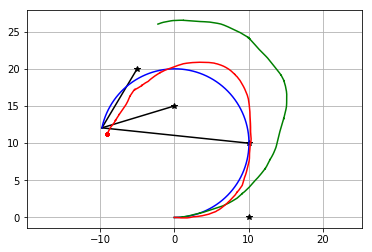

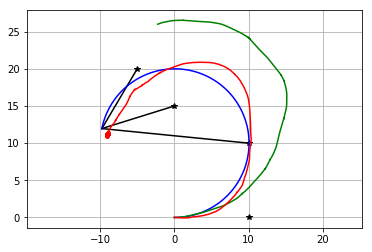

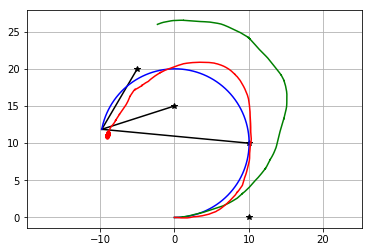

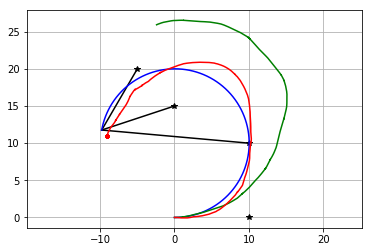

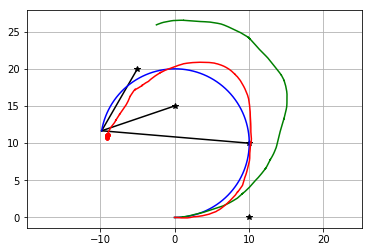

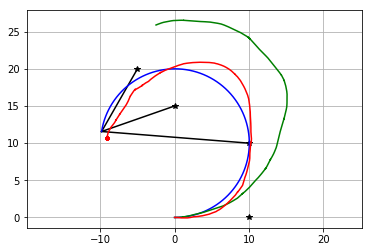

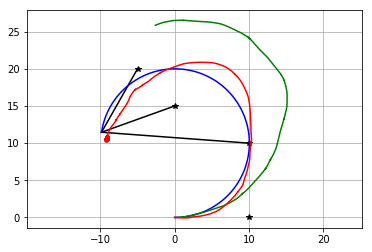

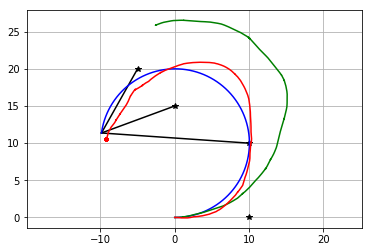

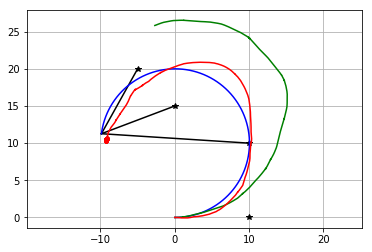

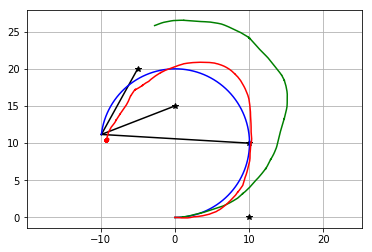

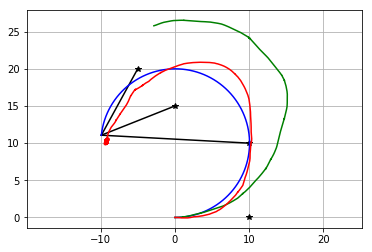

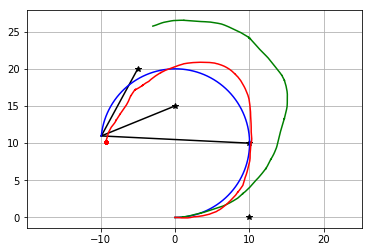

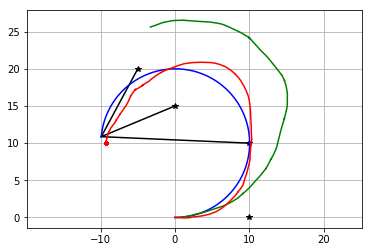

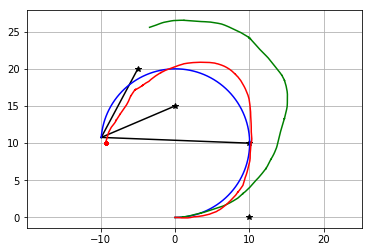

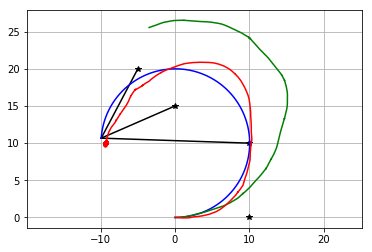

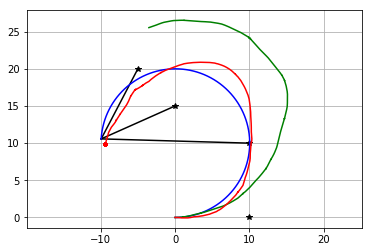

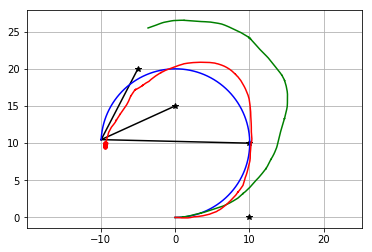

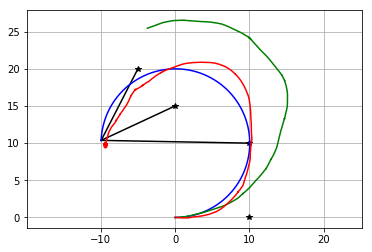

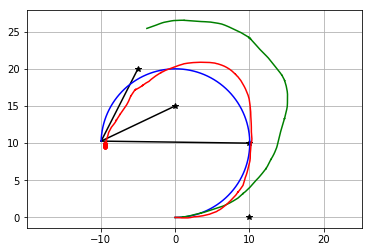

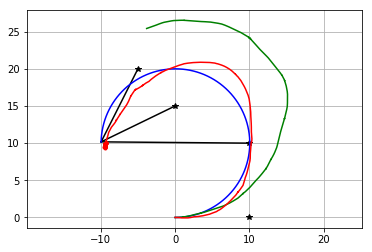

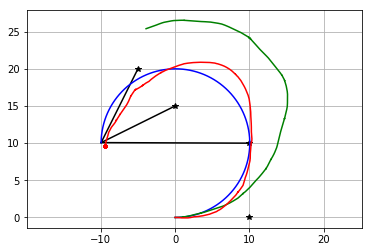

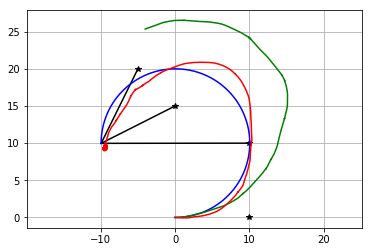

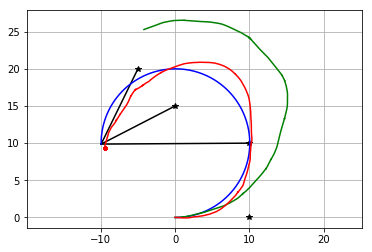

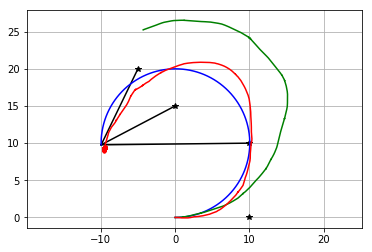

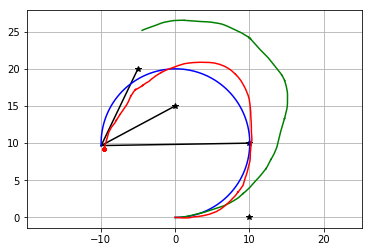

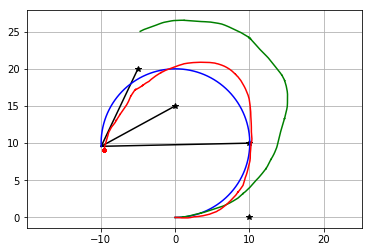

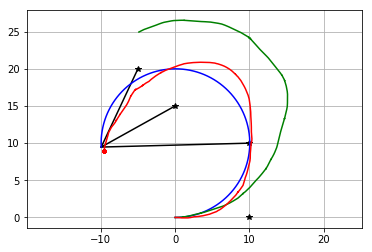

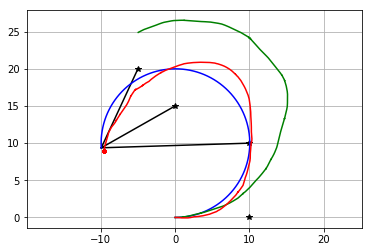

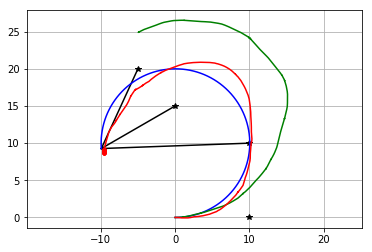

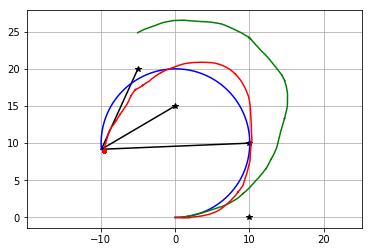

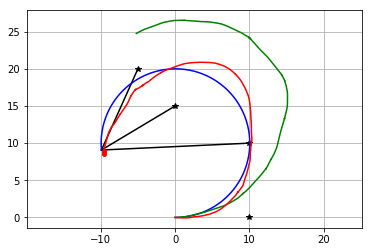

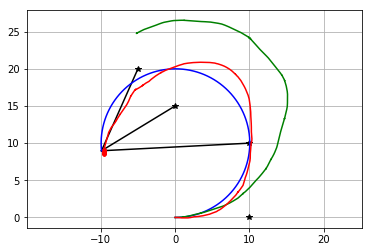

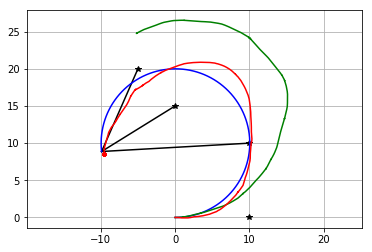

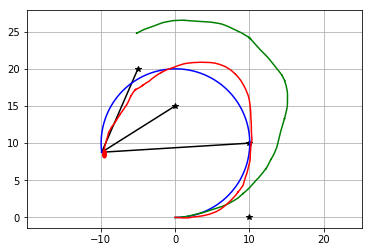

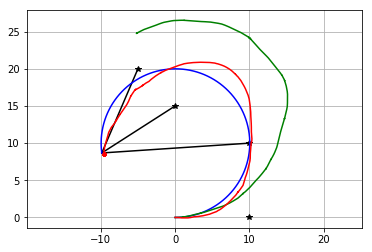

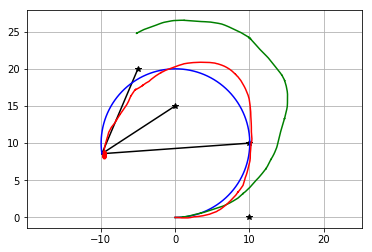

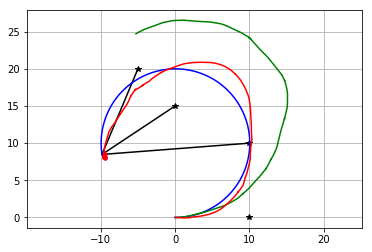

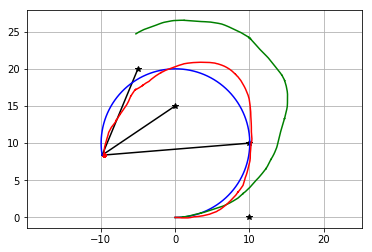

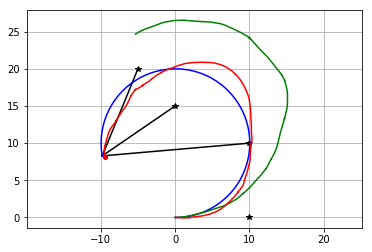

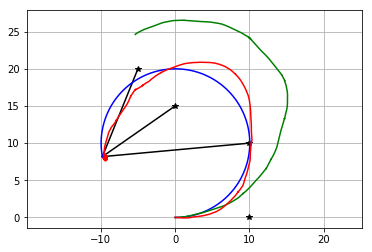

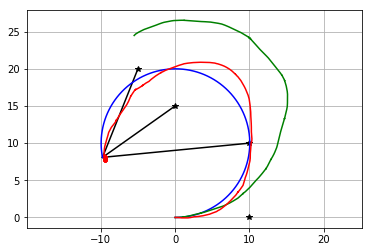

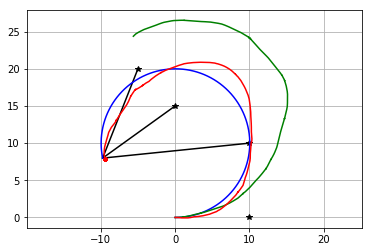

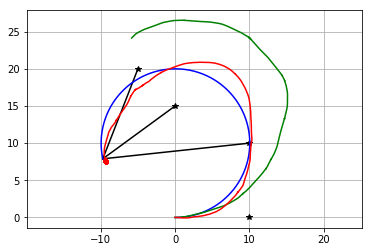

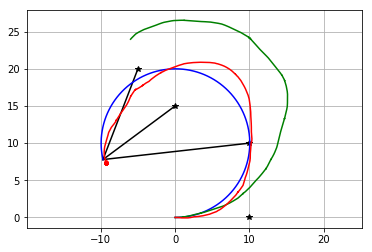

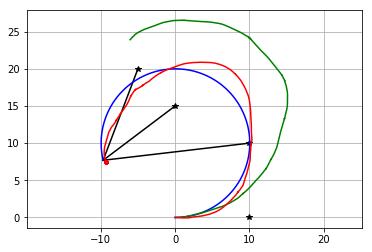

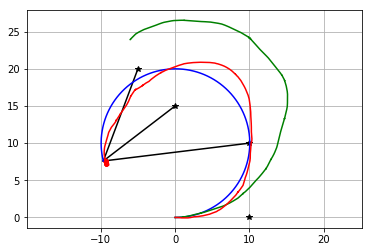

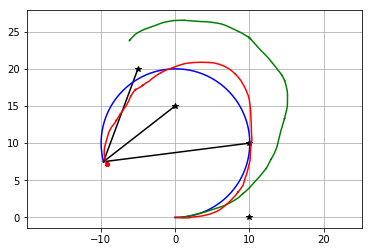

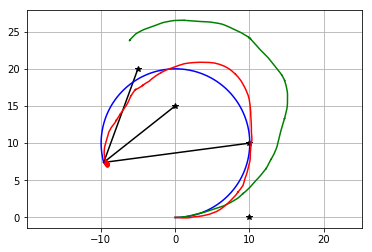

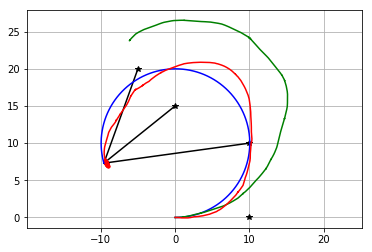

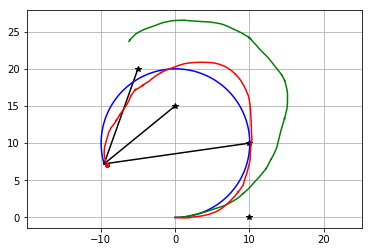

In [11]:
if __name__ == '__main__':
    main()